# Semantic Segmentation of Mars Surface Images

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

# Shared
%cd /gdrive/My Drive/


!pip install keras_cv

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/18CUeQsYpfmDX4HPu9Ps4mChukLfn7wAQ/Homework 2


In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os
from datetime import datetime

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Check Tensor flow and Keras versions
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")

# Check if TensorFlow can access GPUs
# print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

# Import other libraries
import os
import math
from PIL import Image
import pandas as pd
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

# # # Set mixed precision policy
from keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
# policy = mixed_precision.Policy("mixed_bfloat16")
mixed_precision.set_global_policy(policy)  # Updated method name

# # Verify the policy has been set
# print('Compute dtype: %s' % policy.compute_dtype)
# print('Variable dtype: %s' % policy.variable_dtype)

from datetime import datetime
from sklearn.metrics import classification_report, jaccard_score
import pprint
import keras_cv
from rich import print as rprint


TensorFlow version: 2.17.1
Keras version: 3.5.0


## Function definitions

### MeanIntersectionOverUnion

In [ ]:
from tensorflow.keras.saving import register_keras_serializable

# Define custom Mean Intersection Over Union metric
@register_keras_serializable()
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
  def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
    super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
    if labels_to_exclude is None:
      labels_to_exclude = [0]  # Default to excluding label 0
    self.labels_to_exclude = labels_to_exclude

  def update_state(self, y_true, y_pred, sample_weight=None):
    # y_true has to be onehot encoded

    # Convert predictions to class labels
    y_pred = tf.math.argmax(y_pred, axis=-1)
    y_true = tf.math.argmax(y_true, axis=-1)

    # Flatten the tensors
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])

    # Apply mask to exclude specified labels
    for label in self.labels_to_exclude:
      mask = tf.not_equal(y_true, label)
      y_true = tf.boolean_mask(y_true, mask)
      y_pred = tf.boolean_mask(y_pred, mask)

    # Update the state
    return super().update_state(y_true, y_pred, sample_weight)

### Losses


In [ ]:
def apply_label_smoothing(y_true, smoothing=0.1):
    num_classes = tf.cast(tf.shape(y_true)[-1], tf.float32)  # Number of classes
    return y_true * (1 - smoothing) + (smoothing / num_classes)

def bce_loss(class_weights=None, label_smoothing = None):
    def loss(y_true, y_pred):
        if label_smoothing is not None:
          y_true = apply_label_smoothing(y_true, label_smoothing)

        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        bce = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)

        # Apply class weights if provided
        if class_weights is not None:
            weights_tensor = tf.constant(class_weights, dtype=bce.dtype)
            bce = bce * weights_tensor  # Weight each class/channel independently

        return tf.reduce_mean(bce)
    return loss

def cce_loss(class_weights=None, label_smoothing=None):
    def loss(y_true, y_pred):
        if label_smoothing is not None:
          y_true = apply_label_smoothing(y_true, label_smoothing)

        # Clip predictions to avoid log(0) errors
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        # Compute Categorical Cross-Entropy
        cce = -y_true * tf.math.log(y_pred)  # Categorical Cross-Entropy formula
        # Apply class weights if provided
        if class_weights is not None:
            weights_tensor = tf.constant(class_weights, dtype=tf.float32)
            cce = cce * weights_tensor  # Apply weights per class

        cce = tf.reduce_sum(cce, axis=-1)
        return tf.reduce_mean(cce)
    return loss


def dice_loss(class_weights=None):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        intersection = tf.reduce_sum(y_true * y_pred)
        union = tf.reduce_sum(y_true + y_pred)
        dice = 1 - (2 * intersection + tf.keras.backend.epsilon()) / (union + tf.keras.backend.epsilon())

        # Apply class weights if provided
        if class_weights is not None:
            weights_tensor = tf.constant(class_weights, dtype=tf.float32)
            dice = dice * weights_tensor

        return tf.reduce_mean(dice)
    return loss


def focal_loss(gamma=2.0, class_weights=None):
    def loss(y_true, y_pred):
        # Ensure predictions are in the range [epsilon, 1 - epsilon]
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

        # Calculate cross-entropy loss
        ce_loss = -y_true * tf.math.log(y_pred)
        # Apply the focal modulation
        focal_modulation = (1.0 - y_pred) ** gamma
        focal_loss = focal_modulation * ce_loss

        # Apply class weights if provided
        if class_weights is not None:
            weights_tensor = tf.constant(class_weights, dtype=focal_loss.dtype)
            focal_loss = weights_tensor * focal_loss

        # Reduce across spatial dimensions (if applicable) and compute the sum
        focal_loss = tf.reduce_sum(focal_loss, axis=-1)  # Sum across classes
        return tf.reduce_mean(focal_loss)  # Return the mean over the batch

    return loss

def jaccard_loss(class_weights=None):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        intersection = tf.reduce_sum(y_true * y_pred)
        union = tf.reduce_sum(y_true + y_pred - y_true * y_pred)
        jaccard = 1 - (intersection + tf.keras.backend.epsilon()) / (union + tf.keras.backend.epsilon())

        # Apply class weights if provided
        if class_weights is not None:
            weights_tensor = tf.constant(class_weights, dtype=tf.float32)
            jaccard = jaccard * weights_tensor

        return tf.reduce_mean(jaccard)
    return loss


# def combined_loss(loss_fns, weights=None):
#     if weights is None:
#         weights = [1.0] * len(loss_fns)  # Equal weight for all losses by default

#     def loss(y_true, y_pred):
#         total_loss = 0
#         for weight, loss_fn in zip(weights, loss_fns):
#             total_loss += weight * loss_fn(y_true, y_pred)
#         return total_loss
#     return loss


### get_loss_function

In [ ]:
def get_loss_function(loss_string, weights=None, class_weights=None):
    """
    Generate a combined loss function based on a string and weights.

    Args:
        loss_string (str): A string of loss names separated by underscores (e.g., 'focal_dice_bce').
        weights (list of float, optional): Weights for each loss. If None, equal weights are applied.
        class_weights (list of list or ndarray, optional): List of class weight arrays, one for each loss.

    Returns:
        function: Combined loss function.
    """
    # Define individual loss functions
    def bce_loss_fn(class_weights=None):
        return bce_loss(class_weights=class_weights)  # Directly returns the callable loss function

    def cce_loss_fn(class_weights=None):
        return cce_loss(class_weights=class_weights)

    def focal_loss_fn(class_weights=None):
        return focal_loss(class_weights=class_weights)

    def dice_loss_fn(class_weights=None):
        return dice_loss(class_weights=class_weights)

    def jaccard_loss_fn(class_weights=None):
            return jaccard_loss(class_weights=class_weights)


    # Dictionary mapping loss names to their functions
    loss_dict = {
        "bce": bce_loss_fn,
        "cce": cce_loss_fn,
        "focal": focal_loss_fn,
        "dice": dice_loss_fn,
        "jaccard": jaccard_loss_fn
    }

    # Parse the loss string and create a list of loss functions
    loss_names = loss_string.split("_")
    loss_functions = []

    # Ensure class_weights is properly handled
    if class_weights is None:
        class_weights = [None] * len(loss_names)

    if len(class_weights) != len(loss_names):
        raise ValueError("Number of class_weights arrays must match the number of losses in the string.")

    for loss_name, cw in zip(loss_names, class_weights):
        # print(loss_name, cw)
        if loss_name in loss_dict:
            loss_functions.append(loss_dict[loss_name](class_weights=cw))
        else:
            raise ValueError(f"Invalid loss name: {loss_name}. Valid options are: {', '.join(loss_dict.keys())}")

    # Set default weights if not provided
    if weights is None:
        weights = [1 / len(loss_functions)] * len(loss_functions)

    if len(weights) != len(loss_functions):
        raise ValueError("Number of weights must match the number of losses in the string.")

    # Create combined loss function
    def combined_loss(y_true, y_pred):
        total_loss = 0
        for loss_fn, weight in zip(loss_functions, weights):
            total_loss += weight * loss_fn(y_true, y_pred)
        return total_loss

    return combined_loss


### make_dataset


In [ ]:
def make_dataset(images, labels, batch_size, shuffle=True, augment=False, augmentation = None, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    if augment and augmentation is not None:
        dataset = dataset.map(
            lambda x, y: augment_decision(x, y, augmentation, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

### Augmentation


In [ ]:
def augment_decision(image, mask, transform, seed=None):
    prob = tf.cond(
        tf.reduce_any(mask[:,:,4] == 1),
        lambda: tf.constant(0.8, dtype=tf.float32),
        lambda: tf.constant(0.5, dtype=tf.float32)
    )

    if tf.random.uniform((), seed=seed) < prob:      # Apply the same rotation to both
      return augment_preprocess(image, mask, transform, seed=seed)
    else:
      return image, mask

CONCAT = False

def augment_preprocess(image, mask, transforms, seed=None):
    image_dtype = image.dtype
    mask_dtype = mask.dtype

    # Cast to float32 for transformations
    image = tf.cast(image, tf.float32)
    mask = tf.cast(mask, tf.float32)

    # Stack the image and mask along the channel axis
    combined = tf.concat([image, mask], axis=-1)

    if CONCAT:
        for transform in transforms:
            combined = transform(combined)
        transformed_combined = combined
    else:
        index = tf.random.uniform((), minval=0, maxval=len(transforms), dtype=tf.int32, seed=seed)
        # Define a function to apply each transform dynamically
        def apply_transform(idx):
            return transforms[idx](combined)

        transformed_combined = tf.switch_case(
            branch_index=index,
            branch_fns={i: lambda i=i: apply_transform(i) for i in range(len(transforms))}
        )

    # Split the rotated image and mask
    image_channels = image.shape[-1]
    transformed_image = transformed_combined[..., :image_channels]  # First image_channels
    transformed_mask = transformed_combined[..., image_channels:]  # Remaining channels for mask

    transformed_image = tf.cast(transformed_image, image_dtype)
    transformed_mask = tf.cast(transformed_mask, mask_dtype)

    return transformed_image, transformed_mask

# Flip layer
flip_layer = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=seed)

# Rotation layer
rotation_layer = tf.keras.layers.RandomRotation(factor=0.1, fill_mode="reflect", interpolation="bilinear", seed = seed)

# Translation layer
translation_layer = tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="reflect", interpolation="bilinear", seed = seed)

# Zoom layer
zoom_layer = tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2, fill_mode="reflect", interpolation="bilinear", seed = seed)

# Gaussian Noise layer
gaussian_noise_layer = tf.keras.layers.GaussianNoise(stddev=0.3, seed=seed)

# Guassian blur layer
gaussian_blur_layer = keras_cv.layers.RandomGaussianBlur(kernel_size=3, factor=0.7,seed=seed)

# Contrast Adjustment Layer
contrast_layer = tf.keras.layers.RandomContrast(factor=0.2)

# Augmix layer
aug_mix_layer = keras_cv.layers.AugMix(value_range=(0,1), seed=seed,)


# layers = [None,gaussian_noise_layer,gaussian_blur_layer,flip_layer,rotation_layer,translation_layer,zoom_layer,contrast_layer]
# names = ["control","Gaussian Noise","Gaussian Blur", "Flip","Rotation","Translation","Zoom","Contrast"]

### VizCallback

In [ ]:
# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, colormap, frequency=5):
        super().__init__()
        self.image = image
        self.label = label
        self.frequency = frequency
        self.colormap = colormap


    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = self.image, self.label

            # Plot images
            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image, cmap='gray')
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            # label has to be label encoded
            label = tf.math.argmax(label, axis=-1)
            plt.imshow(self.colormap[label.numpy().astype(int)])
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            image = image.reshape(1,64,128,1)
            pred = self.model.predict(image, verbose=0)
            # check if pred is a list
            if isinstance(pred, list):
                pred = pred[-1]
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            plt.subplot(1, 3, 3)
            plt.imshow(self.colormap[y_pred[0].astype(int)])
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

### compute_class_weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

def compute_class_weights(masks):
    masks = np.argmax(masks, axis=-1).reshape(-1)
    class_weights = compute_class_weight('balanced', classes=np.unique(masks), y=masks)
    return class_weights.tolist()

### plot_history

In [ ]:
def plot_history(history):
    # Plot and display training and validation loss
    plt.figure(figsize=(12, 4))
    plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
    plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
    plt.title('DICE')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # Plot and display training and validation accuracy
    plt.figure(figsize=(12, 4))
    plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
    plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
    plt.title('Accuracy')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # Plot and display training and validation mean IoU
    plt.figure(figsize=(12, 4))
    plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
    plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
    plt.title('Mean Intersection over Union')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

### plot_triptychs

In [ ]:
def plot_triptychs(images, labels=None, model=None, colormap=None, num_samples=1):
    """
    Plot triptychs (original image, true mask, predicted mask) for samples from a dataset.

    Parameters:
    images: np.ndarray - Array of input images.
    labels: np.ndarray or None - Array of ground truth masks, or None if not available.
    model: tf.keras.Model or None - The trained model to generate predictions, or None to skip predictions.
    colormap: np.ndarray - A colormap to visualize the labels and predictions.
    num_samples: int - Number of samples to plot.
    """
    for _ in range(num_samples):
        # Select a random sample
        if len(images) == 10022 and num_samples == 1:
            i = 3611
        else:
            i = random.randint(0, len(images) - 1)

        # Generate predictions if a model is provided
        if model is not None:
            pred = model.predict(images[i].reshape(1, *images.shape[1:]), verbose=0)
            if isinstance(pred, list):
                pred = pred[-1]
            pred = tf.math.argmax(pred, axis=-1).numpy()

        # Determine the number of subplots
        num_plots = 1  # Start with just the image
        if labels is not None:
            num_plots += 1  # Add true mask
        if model is not None:
            num_plots += 1  # Add predicted mask

        # Create subplots
        fig, axes = plt.subplots(1, num_plots, figsize=(4 * num_plots, 3))
        if not isinstance(axes, np.ndarray):
            axes = [axes]

        # Plot original image
        axes[0].set_title("Original Image")
        axes[0].imshow(images[i], cmap='gray')
        axes[0].axis('off')

        plot_index = 1

        # Plot predicted mask if model is provided
        if model is not None:
            axes[plot_index].set_title("Predicted Mask")
            if colormap is not None:
                colored_pred = colormap[pred[0].astype(int)]
                axes[plot_index].imshow(colored_pred)
            else:
                axes[plot_index].imshow(pred[0], cmap='viridis')
            axes[plot_index].axis('off')
            plot_index += 1

        # Plot true mask if available
        if labels is not None:
            true_mask = tf.math.argmax(labels[i], axis=-1)
            axes[plot_index].set_title("True Mask")
            if colormap is not None:
                colored_label = colormap[true_mask.numpy().astype(int)]
                axes[plot_index].imshow(colored_label)
            else:
                axes[plot_index].imshow(true_mask.numpy(), cmap='viridis')
            axes[plot_index].axis('off')

        plt.tight_layout()
        plt.show()


### LearningRateLogger


In [ ]:
class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Get the current learning rate from the optimizer
        learning_rate = self.model.optimizer.learning_rate
        # Handle the case where the learning rate is a schedule
        if isinstance(learning_rate, tf.keras.optimizers.schedules.LearningRateSchedule):
            learning_rate = learning_rate(self.model.optimizer.iterations)
        # Format the learning rate to 6 significant digits
        formatted_lr = f"{learning_rate.numpy():.6f}"
        print(f"Epoch {epoch + 1}: Learning Rate is {formatted_lr}")


### y_to_df

In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

### additonal_metrics

In [ ]:
def additonal_metrics(result_entry, y_true, y_pred, verbose = 1):
    # Calculate additional metrics
    final_precision = round(precision_score(y_true, y_pred, average="weighted") * 100, 2)
    final_recall = round(recall_score(y_true, y_pred, average="weighted") * 100, 2)
    final_f1 = round(f1_score(y_true, y_pred, average="weighted") * 100, 2)

    if verbose > 1:
        print(f'Final precision:  {final_precision:6.2f}%')
        print(f'Final recall:     {final_recall:6.2f}%')
        print(f'Final F1-score:   {final_f1:6.2f}%')

    # Append overall metrics
    result_entry["final_precision"] = final_precision
    result_entry["final_recall"] = final_recall
    result_entry["final_f1"] = final_f1
    result_entry["classes"] = []

    true_unique, true_counts = np.unique(y_true, return_counts=True)
    pred_unique, pred_counts = np.unique(y_pred, return_counts=True)

    if len(true_unique) != len(pred_unique):
        # Initialize a zero array for all true_unique classes
        whole_pred_count = np.zeros(len(true_unique), dtype=int)

        # Map pred_counts to the correct positions
        for idx, class_val in enumerate(true_unique):
            if class_val in pred_unique:
                # Find the index of class_val in pred_unique
                pred_index = np.where(pred_unique == class_val)[0][0]
                whole_pred_count[idx] = pred_counts[pred_index]
        pred_counts = whole_pred_count

    ########################### CLASS METRICS ##################################

    # Calculate class-wise metrics
    class_report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    jaccard_scores = jaccard_score(y_true, y_pred, average=None)
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_accuracies = (conf_matrix.diagonal() / conf_matrix.sum(axis=1)) * 100

    if verbose > 0:
      print("Class-wise metrics:")

    for class_idx, class_name in enumerate(class_report.keys()):
        if class_name not in {"accuracy", "macro avg", "weighted avg"}:
            class_precision = round(class_report[class_name]["precision"] * 100, 2)
            class_recall = round(class_report[class_name]["recall"] * 100, 2)
            class_f1 = round(class_report[class_name]["f1-score"] * 100, 2)
            class_mIoU = round(jaccard_scores[class_idx] * 100, 2)
            class_accuracy = round(class_accuracies[class_idx], 2) if not np.isnan(class_accuracies[class_idx]) else 0.0

            if verbose > 0:
                # Prepare metrics strings
                additional_metrics = ""
                if verbose > 1:
                    additional_metrics = (
                        ", "
                        f"Precision = {class_precision:6.2f}%, "
                        f"Recall = {class_recall:6.2f}%, "
                        f"F1-score = {class_f1:6.2f}%"
                    )

                # Print metrics
                print(
                    f"Class {class_idx}: "
                    f"Accuracy = {class_accuracy:6.2f}%, "
                    f"IoU = {class_mIoU:6.2f}%, "
                    f"\tTC = {true_counts[class_idx]}, "
                    f"\tPC = {pred_counts[class_idx]}"
                    f"{additional_metrics}"
                )


            class_metrics = {
                "class_index": class_idx,
                "class_count": true_counts[class_idx],
                "class_pred" : pred_counts[class_idx],
                "class_accuracy": class_accuracy,
                "class_meanIoU": class_mIoU,
                "class_precision": class_precision,
                "class_recall": class_recall,
                "class_f1_score": class_f1
            }

            result_entry["classes"].append(class_metrics)

    return result_entry

### get_model

In [ ]:
def get_model(model_name, input_shape, num_classes, seed, num_levels):
    models = {
        "unet":                 lambda: get_unet_model(input_shape=input_shape, num_classes=num_classes, seed=seed, num_levels=num_levels),
        "unet_conv_transpose":  lambda: get_UNet_model_conv_transpose(input_shape=input_shape, num_classes=num_classes, seed=seed, num_levels=num_levels),
        "residual_unet":        lambda: get_residual_UNet(input_shape=input_shape, num_classes=num_classes, seed=seed, num_levels=num_levels),
        "unet_plus_plus":       lambda: get_unet_plus_plus_model(input_shape=input_shape, num_classes=num_classes, seed=seed, num_levels=num_levels, deep_supervision=False),
        "att_unet_conv_transpose": lambda: get_UNet_model_conv_transpose_with_attention(input_shape=input_shape, num_classes=num_classes, seed=seed, num_levels=num_levels),
        "unet_3_plus" :         lambda: get_unet3_plus_model(input_shape=input_shape, num_classes=num_classes, seed=seed, num_levels=num_levels, base_filters=32, skip_filters=64),
        "att_unet_3_plus": lambda: get_attention_unet3_plus_model(input_shape=input_shape, num_classes=num_classes, seed=seed, num_levels=num_levels, base_filters=32, skip_filters=64),
        }

    # Default to raising an error if model_name is invalid
    if model_name not in models:
        raise ValueError(f"Invalid model name: {model_name}. Valid options are: {', '.join(models.keys())}")

    # Return the selected model
    return models[model_name]()
    # Default to raising an error if model_name is invalid
    if model_name not in models:
        raise ValueError(f"Invalid model name: {model_name}. Valid options are: {', '.join(models.keys())}")

    # Return the selected model
    return models[model_name]()


### create_config_variants

In [ ]:
def create_config_variants(config):
    # Find keys that are lists and exclude "LOSS_WEIGHTS" and "CLASS_WEIGHTS"
    list_keys = [key for key, value in config.items() if isinstance(value, list) and key not in ["LOSS_WEIGHTS", "CLASS_WEIGHTS","AUGMENTATION"]]
    list_lengths = [len(config[key]) for key in list_keys]

    # Check for length mismatch among lists
    if len(set(list_lengths)) > 1:
        raise ValueError("Length mismatch between lists in configuration.")

    # Determine if LOSS_WEIGHTS is multidimensional
    if isinstance(config.get("LOSS_WEIGHTS"), list) and any(isinstance(i, list) for i in config["LOSS_WEIGHTS"]):
        loss_weights_variants = config["LOSS_WEIGHTS"]
    else:
        loss_weights_variants = [config["LOSS_WEIGHTS"]]

    # Determine if AUGMENTATION is multidimensional
    if isinstance(config.get("AUGMENTATION"), list) and any(isinstance(i, list) for i in config["AUGMENTATION"]):
        augmentation_variants = config["AUGMENTATION"]
    else:
        augmentation_variants = [config["AUGMENTATION"]]


    # Determine if CLASS_WEIGHTS is a list of list of lists
    if isinstance(config.get("CLASS_WEIGHTS"), list) and any(isinstance(i, list) and any(isinstance(j, list) for j in i) for i in config["CLASS_WEIGHTS"]):
        class_weights_variants = config["CLASS_WEIGHTS"]
    else:
        class_weights_variants = [config["CLASS_WEIGHTS"]]

    # Determine the number of variants
    num_variants = max(
        len(loss_weights_variants),
        len(class_weights_variants),
        len(augmentation_variants),
        list_lengths[0] if list_keys else 1
    )

    # Create the variants as a list of dictionaries
    variants = []
    for i in range(num_variants):
        variant = {}
        for key, value in config.items():
            if key in list_keys:
                variant[key] = value[i]
            elif key == "LOSS_WEIGHTS":
                variant[key] = loss_weights_variants[i % len(loss_weights_variants)]
            elif key == "AUGMENTATION":
                variant[key] = augmentation_variants[i % len(augmentation_variants)]
            elif key == "CLASS_WEIGHTS":
                variant[key] = class_weights_variants[i % len(class_weights_variants)]
            else:
                variant[key] = value  # Keep non-list values unchanged
        variants.append(variant)

    return variants


### create_binary_background_mask

In [ ]:

def create_binary_background_mask(segmentation_mask, foreground_classes=[1, 2, 3, 4]):
    # Binary mask: 1 for any foreground, 0 for background
    background_mask = np.isin(segmentation_mask, foreground_classes).astype(np.uint8)
    return background_mask  # Invert to focus on background


### make_mixed_prediction

In [ ]:
def make_mixed_predictions(dataset, binary_model_name, multi_model_name):
    binary_model = tf.keras.models.load_model(binary_model_name, compile = False)
    binary_output = binary_model.predict(dataset)  # Binary output (foreground/background), shape (H, W, 1)


    multiclass_model = tf.keras.models.load_model(multi_model_name, compile=False)
    multiclass_output = multiclass_model.predict(dataset)  # Multiclass output, shape (H, W, num_classes)

    mixed_output = multiclass_output.copy()

    # Extract background probability from the binary model
    background_prob = binary_output[..., 0]  # Shape: (501, 64, 128)
    foreground_prob = binary_output[..., 1]  # Shape: (501, 64, 128)

    # Thresholding: Adjust the background probability based on the threshold
    background_prob[foreground_prob > 0.8] = 0  # Confident foreground areas become zero for background

    # Apply conditional weighting: amplify background_prob if it's very certain (e.g., > 0.95)
    background_prob = np.where(background_prob > 0.99, background_prob * 1.5, background_prob)

    # Incorporate the adjusted background probability into the 0th class of the multi-class model
    mixed_output[..., 0] += background_prob

    # Rescale the multi-class probabilities to ensure they sum to 1
    mixed_output = np.clip(mixed_output, 0, None)  # Ensure no negative values but allow > 1 temporarily
    mixed_output /= np.sum(mixed_output, axis=-1, keepdims=True) + 1e-6  # Normalize to sum to 1

    # Convert probabilities to class indices
    mixed_prediction = np.argmax(mixed_output, axis=-1)

    return binary_output, multiclass_output, mixed_output


### compare_mixed_outputs

In [ ]:
def compare_mixed_outputs(X_val, y_val,binary_outputs,std_preds, mixed_preds, num_images, colormap):
  # all one hot encoded

  for i in range(num_images):
    # Choose a random image index for visualization
    label_0_coverage = np.mean(y_val[..., 0], axis=(1, 2))  # Calculate label 0 coverage for each image
    image_index = np.random.choice(np.where(label_0_coverage >= 0.5)[0])  # Randomly pick an index meeting the condition

    # image_index = random.randint(0, len(X_val) - 1)

    # Get the image, true mask, multi-output mask, and final model output
    image = X_val[image_index]
    true_mask =         np.argmax(y_val[image_index], axis=-1)
    multi_output_mask = np.argmax(std_preds[image_index], axis=-1)
    final_output_mask = np.argmax(mixed_preds[image_index], axis=-1)

    # Create a figure with subplots
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))

    # Plot the image
    axes[0].imshow(image[..., 0], cmap='gray')
    axes[0].set_title("Image")

    # Plot the true mask
    # apply colormap
    colored_pred = colormap[true_mask.astype(int)]
    axes[1].imshow(colored_pred)
    axes[1].set_title("True Mask")

    axes[2].set_title("Binary Mask")
    axes[2].imshow(binary_output[image_index][..., 1], cmap='gray')

    # Plot the multi-output mask
    colored_pred = colormap[multi_output_mask.astype(int)]
    axes[3].imshow(colored_pred)
    axes[3].set_title("Multi-Label Mask")

    # Plot the final model output mask
    colored_pred = colormap[final_output_mask.astype(int)]
    axes[4].imshow(colored_pred)
    axes[4].set_title("Mixed Output Mask")

    # Display the plots
    plt.show()

## Build the Model

### Basic Blocks

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [ ]:
def attention_gate(F_e, F_d, filters, name="attention_gate"):
    """
    Attention Gate for U-Net.

    Args:
    - F_e: Encoder feature map (high resolution).
    - F_d: Decoder feature map (low resolution).
    - filters: Number of filters for the intermediate convolution layers.
    - name: Name of the attention gate.

    Returns:
    - Refined encoder feature map with attention applied.
    """
    # 1x1 Convolution for encoder and decoder features
    g1 = tfkl.Conv2D(filters, kernel_size=1, strides=1, padding="same", name=name+"_conv_g")(F_d)
    x1 = tfkl.Conv2D(filters, kernel_size=1, strides=1, padding="same", name=name+"_conv_x")(F_e)

    # Add and apply ReLU
    add = tfkl.Add(name=name+"_add")([g1, x1])
    relu = tfkl.Activation("relu", name=name+"_relu")(add)

    # 1x1 Convolution for attention coefficients
    psi = tfkl.Conv2D(1, kernel_size=1, strides=1, padding="same", name=name+"_conv_psi")(relu)
    alpha = tfkl.Activation("sigmoid", name=name+"_sigmoid")(psi)

    # Multiply attention coefficients with encoder features
    F_e_refined = tfkl.Multiply(name=name+"_multiply")([F_e, alpha])

    return F_e_refined


In [ ]:
def residual_unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    """
    Defines a Residual U-Net block with residual connections.

    Parameters:
    - input_tensor: tf.Tensor, input to the block.
    - filters: int, number of filters for the Conv2D layers.
    - kernel_size: int or tuple, size of the convolution kernels.
    - activation: string, activation function.
    - stack: int, number of convolutional layers to apply.
    - name: string, base name for the layers.

    Returns:
    - x: tf.Tensor, output of the Residual U-Net block.
    """
    x = input_tensor
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + f'conv{i+1}_')(x)
        x = tfkl.BatchNormalization(name=name + f'bn{i+1}_')(x)
        x = tfkl.Activation(activation, name=name + f'activation{i+1}_')(x)

    # Residual connection
    if input_tensor.shape[-1] != filters:
        # If the number of filters does not match, use a 1x1 convolution to match dimensions
        shortcut = tfkl.Conv2D(filters, kernel_size=1, padding='same', name=name + 'conv_shortcut_')(input_tensor)
        shortcut = tfkl.BatchNormalization(name=name + 'bn_shortcut_')(shortcut)
    else:
        shortcut = input_tensor

    x = tfkl.Add(name=name + 'add_')([x, shortcut])
    x = tfkl.Activation(activation, name=name + 'activation_out_')(x)
    return x



### UNet

In [ ]:
def get_unet_model(input_shape=(64, 128, 1), num_classes=5, seed=None, num_levels=5):
    """
    Constructs a U-Net model with a variable number of downsampling and upsampling steps using transpose convolutions.

    Parameters:
    - input_shape: tuple, the shape of the input tensor (height, width, channels).
    - num_classes: int, the number of output classes.
    - seed: int or None, for reproducibility.
    - num_levels: int, the number of downsampling/upsampling levels.

    Returns:
    - model: tf.keras.Model, the constructed U-Net model.
    """
    if seed is not None:
        tf.random.set_seed(seed)

    # Define the number of filters for each level
    base_filters = 32
    filters = [base_filters * (2 ** i) for i in range(num_levels)]

    # Input layer
    inputs = tfkl.Input(shape=input_shape, name='input_layer')
    x = inputs
    skips = []

    # Downsampling path
    for i in range(num_levels):
        x = unet_block(x, filters[i], name=f'down_block{i+1}_')
        skips.append(x)
        x = tfkl.MaxPooling2D(pool_size=(2, 2), name=f'down_pool{i+1}')(x)

    # Bottleneck
    bottleneck_filters = filters[-1] * 2
    bottleneck = unet_block(x, bottleneck_filters, name='bottleneck_')

    # Upsampling path
    x = bottleneck
    for i in reversed(range(num_levels)):
        # Transpose Convolution for upsampling
        x = tfkl.UpSampling2D(name=f'up_sampling{i+1}_')(x)
        # Concatenate with corresponding skip connection
        x = tfkl.Concatenate(name=f'concat_up{i+1}_')([x, skips[i]])
        # Apply U-Net block
        x = unet_block(x, filters[i], name=f'up_block{i+1}_')

    # Output layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same',
                               activation="softmax", name='output_layer')(x)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=output_layer, name='UNet')
    return model


### UNet with Conv Upsampling

In [ ]:
def get_UNet_model_conv_transpose(input_shape=(64, 128, 1), num_classes=5, seed=None, num_levels=5):
    """
    Constructs a U-Net model with variable downsampling and upsampling steps using transpose convolutions.

    Parameters:
    - input_shape: tuple, the shape of the input tensor.
    - num_classes: int, the number of output classes.
    - seed: int or None, for reproducibility.
    - num_levels: int, the number of downsampling/upsampling levels.

    Returns:
    - model: tf.keras.Model, the constructed U-Net model.
    """
    if seed is not None:
        tf.random.set_seed(seed)

    # Define the number of filters for each level
    # This can be adjusted or made dynamic as needed
    base_filters = 32
    filters = [base_filters * (2 ** i) for i in range(num_levels)]

    # Input layer
    inputs = tfkl.Input(shape=input_shape, name='input_layer')
    x = inputs
    skips = []

    # Downsampling path
    for i in range(num_levels):
        x = unet_block(x, filters[i], name=f'down_block{i+1}_')
        skips.append(x)
        # Use MaxPooling2D to reduce spatial dimensions
        x = tfkl.MaxPooling2D(pool_size=(2, 2), name=f'down_pool{i+1}')(x)

    # Bottleneck
    bottleneck_filters = filters[-1] * 2
    bottleneck = unet_block(x, bottleneck_filters, name='bottleneck_')

    # Upsampling path
    for i in reversed(range(num_levels)):
        # Use Conv2DTranspose for upsampling
        x = tfkl.Conv2DTranspose(filters[i], kernel_size=2, strides=2, padding='same',
                                 name=f'up_transpose{i+1}_')(bottleneck if i == num_levels -1 else x)
        # Concatenate with the corresponding skip connection
        x = tfkl.Concatenate(name=f'concat_up{i+1}_')([x, skips[i]])
        # Apply U-Net block
        x = unet_block(x, filters[i], name=f'up_block{i+1}_')
        bottleneck = x  # Update bottleneck for the next iteration

    # Output layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same',
                               activation='softmax', name='output_layer')(x)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=output_layer, name='ConvUNet')

    return model

### Weighted UNet

In [ ]:
def weighted_add(input1, input2, name='weighted_add'):
    """
    Perform a learnable weighted addition of two input tensors.

    Args:
    - input1, input2: Input tensors to merge.
    - name: Name prefix for the layers created.

    Returns:
    - Tensor resulting from the weighted addition of input1 and input2.
    """
    # Learnable weights for input1 and input2
    w1 = tf.Variable(initial_value=0.5, trainable=True, dtype=tf.float32, name=name + '_w1')
    w2 = tf.Variable(initial_value=0.5, trainable=True, dtype=tf.float32, name=name + '_w2')

    # Normalize weights to ensure they sum to 1
    w_sum = w1 + w2
    w1_normalized = w1 / w_sum
    w2_normalized = w2 / w_sum

    # Weighted addition
    return w1_normalized * input1 + w2_normalized * input2


In [ ]:
def get_unet_model(input_shape=(64, 128, 1), num_classes=5, seed=None):
    """
    Build a U-Net model with learnable weighted additions in the skip connections.

    Args:
    - input_shape: Shape of the input image.
    - num_classes: Number of output classes.
    - seed: Random seed for reproducibility.

    Returns:
    - A Keras Model object.
    """
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_', kernel_size=3)
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_', kernel_size=3)
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 128, name='down_block3_', kernel_size=5)
    d3 = tfkl.MaxPooling2D()(down_block_3)

    down_block_4 = unet_block(d3, 256, name='down_block4_', kernel_size=5)
    d4 = tfkl.MaxPooling2D()(down_block_4)

    # Additional downsampling to reduce the resolution to (1, 2)
    down_block_5 = unet_block(d4, 512, name='down_block5_', kernel_size=3)
    d5 = tfkl.MaxPooling2D(pool_size=(2, 2))(down_block_5)

    # Bottleneck
    bottleneck = unet_block(d5, 1024, name='bottleneck', kernel_size=3)

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Conv2D(512, kernel_size=3, padding='same', name='conv')(u1)
    u1 = weighted_add(u1, down_block_5, name='up_block1_merge')
    u1 = unet_block(u1, 256, name='up_block1_', kernel_size=3)

    u2 = tfkl.UpSampling2D()(u1)
    u2 = weighted_add(u2, down_block_4, name='up_block2_merge')
    u2 = unet_block(u2, 128, name='up_block2_', kernel_size=5)

    u3 = tfkl.UpSampling2D()(u2)
    u3 = weighted_add(u3, down_block_3, name='up_block3_merge')
    u3 = unet_block(u3, 64, name='up_block3_',kernel_size=5)

    u4 = tfkl.UpSampling2D()(u3)
    u4 = weighted_add(u4, down_block_2, name='up_block4_merge')
    u4 = unet_block(u4, 32, name='up_block4_',kernel_size=3)

    u5 = tfkl.UpSampling2D()(u4)
    u5 = weighted_add(u5, down_block_1, name='up_block5_merge')
    u5 = unet_block(u5, 32, name='up_block5_',kernel_size=3)

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u5)

    # Define the model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='WeightedUNet')
    return model


### Attention UNet with Conv Upsampling

In [ ]:
def get_UNet_model_conv_transpose_with_attention(input_shape=(64, 128, 1), num_classes=5, seed=None, num_levels=5):
    """
    Constructs a U-Net model with attention gates and transpose convolutions for semantic segmentation.

    Parameters:
    - input_shape: tuple, the shape of the input tensor.
    - num_classes: int, the number of output classes.
    - seed: int or None, for reproducibility.
    - num_levels: int, the number of downsampling/upsampling levels.

    Returns:
    - model: tf.keras.Model, the constructed U-Net model.
    """
    if seed is not None:
        tf.random.set_seed(seed)

    # Define the number of filters for each level
    base_filters = 32
    filters = [base_filters * (2 ** i) for i in range(num_levels)]

    # Input layer
    inputs = tfkl.Input(shape=input_shape, name='input_layer')
    x = inputs
    skips = []

    # Downsampling path
    for i in range(num_levels):
        x = residual_unet_block(x, filters[i], name=f'down_block{i+1}_')
        skips.append(x)
        x = tfkl.MaxPooling2D(pool_size=(2, 2), name=f'down_pool{i+1}')(x)

    # Bottleneck
    bottleneck_filters = filters[-1] * 2
    bottleneck = residual_unet_block(x, bottleneck_filters, name='bottleneck_')

    # Upsampling path
    for i in reversed(range(num_levels)):
        # Use Conv2DTranspose for upsampling
        x = tfkl.Conv2DTranspose(filters[i], kernel_size=2, strides=2, padding='same',
                                 name=f'up_transpose{i+1}_')(bottleneck if i == num_levels - 1 else x)

        # Attention gate between encoder and decoder features
        attention = attention_gate(skips[i], x, filters[i], name=f'attention_gate{i+1}_')

        # Concatenate with the refined encoder features
        x = tfkl.Concatenate(name=f'concat_up{i+1}_')([x, attention])

        # Apply U-Net block
        x = residual_unet_block(x, filters[i], name=f'up_block{i+1}_')
        bottleneck = x  # Update bottleneck for the next iteration

    # Output layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same',
                               activation='softmax', name='output_layer')(x)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=output_layer, name='ConvUNet_with_Attention')

    return model


### UNet residual

In [ ]:
def get_residual_UNet(input_shape=(64, 128, 1), num_classes=5, seed=None, num_levels=5):
    """
    Constructs a Residual U-Net model with a variable number of downsampling and upsampling steps using transpose convolutions.

    Parameters:
    - input_shape: tuple, the shape of the input tensor (height, width, channels).
    - num_classes: int, the number of output classes.
    - seed: int or None, for reproducibility.
    - num_levels: int, the number of downsampling/upsampling levels.

    Returns:
    - model: tf.keras.Model, the constructed Residual U-Net model.
    """
    if seed is not None:
        tf.random.set_seed(seed)

    # Define the number of filters for each level
    base_filters = 32
    filters = [base_filters * (2 ** i) for i in range(num_levels)]

    # Input layer
    inputs = tfkl.Input(shape=input_shape, name='input_layer')
    x = inputs
    skips = []

    # Downsampling path
    for i in range(num_levels):
        x = residual_unet_block(x, filters[i], name=f'down_block{i+1}_')
        skips.append(x)
        x = tfkl.MaxPooling2D(pool_size=(2, 2), name=f'down_pool{i+1}')(x)

    # Bottleneck
    bottleneck_filters = filters[-1] * 2
    bottleneck = residual_unet_block(x, bottleneck_filters, name='bottleneck_')

    # Upsampling path
    x = bottleneck
    for i in reversed(range(num_levels)):
        # Transpose Convolution for upsampling
        x = tfkl.Conv2DTranspose(filters[i], kernel_size=2, strides=2, padding='same', name=f'up_transpose{i+1}_')(x)
        # Concatenate with corresponding skip connection
        x = tfkl.Concatenate(name=f'concat_up{i+1}_')([x, skips[i]])
        # Apply Residual U-Net block
        x = residual_unet_block(x, filters[i], name=f'up_block{i+1}_')

    # Output layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same',
                               activation="softmax", name='output_layer')(x)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=output_layer, name='ResidualUNet')
    return model


### Mars Seg


#### Skip connection & bottleneck blocks

##### Mini-ASPP

In [ ]:
from tensorflow.keras.layers import Conv2D, Concatenate, Activation

def mini_aspp(input_tensor, filters):
    """
    Mini-ASPP block implementation.

    Args:
    - input_tensor: Input tensor (batch, H, W, C).
    - filters: Number of filters for each convolutional branch.

    Returns:
    - Enhanced feature map after Mini-ASPP processing.
    """
    # 1x1 Convolution branch
    conv_1x1 = Conv2D(filters, (1, 1), padding="same", activation="relu")(input_tensor)

    # 3x3 Convolution branch with rate=1 (standard convolution)
    conv_3x3_rate1 = Conv2D(filters, (3, 3), padding="same", activation="relu", dilation_rate=1)(input_tensor)

    # 3x3 Convolution branch with rate=2 (dilated/atrous convolution)
    conv_3x3_rate2 = Conv2D(filters, (3, 3), padding="same", activation="relu", dilation_rate=2)(input_tensor)

    # Concatenate the outputs of the three branches
    concatenated = Concatenate()([conv_1x1, conv_3x3_rate1, conv_3x3_rate2])

    # Final 1x1 convolution for feature fusion
    fused = Conv2D(filters, (1, 1), padding="same", activation="relu")(concatenated)

    return fused

##### SPPM ( Strip Pooling Pyramid Module)

In [ ]:
from tensorflow.keras.layers import AveragePooling2D, Conv2D, Concatenate

def strip_pool(input_tensor, axis):
    """
    Stripe pooling along a specific axis (height or width).
    Args:
    - input_tensor: Input tensor (batch, H, W, C).
    - axis: Axis for pooling: 0 for height (1xH), 1 for width (1xW).
    Returns:
    - Strip-pooled tensor reduced along the specified axis.
    """
    if axis == 0:  # Stripe pooling along height (1xH)
        strip_pooled = AveragePooling2D(pool_size=(input_tensor.shape[1], 1), strides=(1, 1), padding="valid")(input_tensor)
    elif axis == 1:  # Stripe pooling along width (1xW)
        strip_pooled = AveragePooling2D(pool_size=(1, input_tensor.shape[2]), strides=(1, 1), padding="valid")(input_tensor)
    return strip_pooled

from tensorflow.keras.layers import UpSampling2D, Conv2D, Concatenate, AveragePooling2D

def sppm(input_tensor, filters):
    """
    Strip Pooling Pyramid Module (SPPM) with upsampling to ensure matching dimensions.
    Args:
    - input_tensor: Input tensor (batch, H, W, C).
    - filters: Number of filters for output features.
    Returns:
    - Feature tensor after SPPM operations.
    """
    # 1. Pyramid Pooling with multiple scales
    pool1 = AveragePooling2D(pool_size=(1, 1), padding='same')(input_tensor)
    pool2 = AveragePooling2D(pool_size=(2, 2), padding='same')(input_tensor)
    pool4 = AveragePooling2D(pool_size=(4, 4), padding='same')(input_tensor)
    pool8 = AveragePooling2D(pool_size=(8, 8), padding='same')(input_tensor)

    # Apply 1x1 convolution to reduce dimensionality
    pool1 = Conv2D(filters, (1, 1), activation="relu", padding="same")(pool1)
    pool2 = Conv2D(filters, (1, 1), activation="relu", padding="same")(pool2)
    pool4 = Conv2D(filters, (1, 1), activation="relu", padding="same")(pool4)
    pool8 = Conv2D(filters, (1, 1), activation="relu", padding="same")(pool8)

    # 2. Stripe Pooling along height and width
    strip_height = strip_pool(input_tensor, axis=0)  # Pool along height (1xH)
    strip_width = strip_pool(input_tensor, axis=1)   # Pool along width (1xW)

    # Apply 1x1 convolution to stripe-pooled outputs
    strip_height = Conv2D(filters, (1, 1), activation="relu", padding="same")(strip_height)
    strip_width = Conv2D(filters, (1, 1), activation="relu", padding="same")(strip_width)

    # 3. Align spatial dimensions using UpSampling2D
    # Upsample all smaller tensors to match the original input_tensor spatial dimensions
    target_height, target_width = input_tensor.shape[1], input_tensor.shape[2]
    pool1 = UpSampling2D(size=(target_height // pool1.shape[1], target_width // pool1.shape[2]))(pool1)
    pool2 = UpSampling2D(size=(target_height // pool2.shape[1], target_width // pool2.shape[2]))(pool2)
    pool4 = UpSampling2D(size=(target_height // pool4.shape[1], target_width // pool4.shape[2]))(pool4)
    pool8 = UpSampling2D(size=(target_height // pool8.shape[1], target_width // pool8.shape[2]))(pool8)
    strip_height = UpSampling2D(size=(target_height // strip_height.shape[1], 1))(strip_height)
    strip_width = UpSampling2D(size=(1, target_width // strip_width.shape[2]))(strip_width)

    # 4. Concatenate all features (pooled and stripe-pooled)
    concatenated = Concatenate()([pool1, pool2, pool4, pool8, strip_height, strip_width])

    # Final 1x1 convolution for feature fusion
    output = Conv2D(filters, (1, 1), activation="relu", padding="same")(concatenated)

    return output

##### PSA

In [ ]:
from tensorflow.keras.layers import Conv2D, Reshape, Softmax, Multiply, Add, LayerNormalization, Activation, Lambda
import tensorflow as tf

def polarized_self_attention(input_tensor):
    """
    Polarized Self-Attention Module.
    Args:
        input_tensor: Input tensor of shape (batch, H, W, C).
    Returns:
        Tensor after applying channel and spatial self-attention.
    """
    # Static input shape
    input_shape = input_tensor.shape  # Static shape: (batch, H, W, C)
    C = input_shape[-1]  # Number of channels (C)

    # Dynamically calculate H and W for symbolic tensors
    H, W = input_shape[1], input_shape[2]
    if H is None or W is None:  # Handle dynamic spatial dimensions
        H = tf.shape(input_tensor)[1]
        W = tf.shape(input_tensor)[2]

    # --- Channel Attention Path ---
    # 1x1 Convolution to reduce channels
    q_channel = Conv2D(C // 2, (1, 1), padding="same")(input_tensor)  # Q
    v_channel = Conv2D(C // 2, (1, 1), padding="same")(input_tensor)  # V

    # Reshape for attention computation
    q_channel_reshaped = Reshape((-1, C // 2))(q_channel)  # (batch, H*W, C/2)
    v_channel_reshaped = Reshape((-1, C // 2))(v_channel)  # (batch, H*W, C/2)

    # Apply softmax along the spatial dimension
    attention_weights_channel = Softmax(axis=1)(q_channel_reshaped)  # Normalize across spatial dimensions
    channel_attention = Multiply()([attention_weights_channel, v_channel_reshaped])  # Weighted attention

    # Reshape back to original spatial dimensions
    channel_attention = Reshape((H, W, C // 2))(channel_attention)
    channel_attention = Conv2D(C, (1, 1), padding="same")(channel_attention)  # Map back to original channels

    # --- Spatial Attention Path ---
    # 1x1 Convolution
    q_spatial = Conv2D(C // 2, (1, 1), padding="same")(input_tensor)  # Q
    v_spatial = Conv2D(C // 2, (1, 1), padding="same")(input_tensor)  # V

    # Global average pooling for Q
    q_spatial_pooled = Lambda(lambda x: tf.reduce_mean(x, axis=[1, 2]))(q_spatial)  # (batch, C/2)

    # Softmax along the channel dimension
    attention_weights_spatial = Softmax(axis=-1)(q_spatial_pooled)  # Normalize across channels
    attention_weights_spatial = Lambda(lambda x: tf.expand_dims(x, axis=1))(attention_weights_spatial)  # (batch, 1, C/2)
    attention_weights_spatial = Lambda(lambda x: tf.expand_dims(x, axis=1))(attention_weights_spatial)  # (batch, 1, 1, C/2)

    # Multiply V_spatial by attention weights
    spatial_attention = Multiply()([attention_weights_spatial, v_spatial])  # (batch, H, W, C/2)
    spatial_attention = Lambda(lambda x: tf.reduce_sum(x, axis=-1, keepdims=True))(spatial_attention)  # (batch, H, W, 1)

    # --- Combine Channel and Spatial Attention ---
    channel_attention = Activation('sigmoid')(channel_attention)
    spatial_attention = Activation('sigmoid')(spatial_attention)

    # Combine the two attentions
    combined_attention = Add()([channel_attention, spatial_attention])  # Weighted sum of attentions
    output_tensor = Multiply()([input_tensor, combined_attention])  # Apply combined attention to input

    # Optional Layer Normalization
    output_tensor = LayerNormalization()(output_tensor)

    return output_tensor

#### Build Encoder

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Concatenate, Add

def encoder_block(input_tensor, filters, strides=2):
    """
    A single block of the encoder.
    Args:
    - input_tensor: Input feature map (batch, H, W, C).
    - filters: Number of filters for the convolutional layer.
    - strides: Stride size for downsampling.
    Returns:
    - Output tensor after applying Conv2D, BatchNorm, and ReLU.
    """
    x = Conv2D(filters, (3, 3), strides=strides, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

def build_encoder(input_tensor):
    """
    Builds the encoder consisting of multiple encoder blocks.
    Args:
    - input_tensor: Input image tensor (batch, 64, 128, 1).
    Returns:
    - List of feature maps from each encoder block (for skip connections).
    """
    skip_connections = []

    # First block: Keep resolution
    x = encoder_block(input_tensor, filters=32, strides=1)  # Output: (64, 128, 32)
    skip_connections.append(x)

    # Downsampling blocks
    x = encoder_block(x, filters=64)  # Output: (32, 64, 64)

    x = encoder_block(x, filters=128)  # Output: (16, 32, 128)
    skip_connections.append(x)

    x = encoder_block(x, filters=256)  # Output: (8, 16, 256)
    skip_connections.append(x)

    x = encoder_block(x, filters=512)  # Output: (4, 8, 512)

    x = encoder_block(x, filters=1024)  # Output: (2, 4, 1024)

    return x, skip_connections

#### Build Decoder

In [ ]:
from tensorflow.keras.layers import UpSampling2D

'''
def decoder_block(input_tensor, skip_connection, filters):

    A single block of the decoder.
    Args:
    - input_tensor: Input feature map from the previous layer (batch, H, W, C).
    - skip_connection: Feature map from the encoder (for skip connection).
    - filters: Number of filters for the convolutional layers.
    Returns:
    - Output tensor after upsampling and merging with skip connection.

    # Upsample using transposed convolution
    x = Conv2DTranspose(filters, (3, 3), strides=(2, 2), padding='same')(input_tensor)  # Upsample

    # Concatenate with skip connection
    x = Concatenate()([x, skip_connection])

    # Apply convolution and normalization
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x
'''

def build_mars_seg(encoded_tensor, skip_connections):
    """
    Builds the decoder network.
    Args:
    - encoded_tensor: Encoder output tensor.
    - skip_connections: List of skip connections from the encoder.
    Returns:
    - Decoder output.
    """
    # First skip connection processing (through Mini-ASPP + PSA)
    skip_1 = mini_aspp(skip_connections[0], filters=128)  # First skip processed by Mini-ASPP
    skip_1 = polarized_self_attention(skip_1)  # Apply PSA to the first skip connection

    # Second skip connection processing (through Mini-ASPP + PSA)
    skip_2 = mini_aspp(skip_connections[1], filters=128)  # Second skip processed by Mini-ASPP
    skip_2 = polarized_self_attention(skip_2)  # Apply PSA to the second skip connection

    # Third skip connection processing (through Mini-ASPP + PSA)
    skip_3 = mini_aspp(skip_connections[2], filters=128)  # Second skip processed by Mini-ASPP
    skip_3 = polarized_self_attention(skip_3)  # Apply PSA to the third skip connection

    # Bottleneck processing (through SPPM)
    x = sppm(encoded_tensor, filters=128)

    # First decoder block: Upsample the encoded features
    x = UpSampling2D(size=(2, 2))(x)  # Upsampling to (4, 8, 1024)
    x = Conv2D(512, (3, 3), padding="same", activation="relu")(x)  # Apply convolution
    x = tfkl.BatchNormalization()(x)  # Apply batch normalization

    # Second decoder block: Upsample and concatenate with processed second skip
    x = UpSampling2D(size=(2, 2))(x)  # Upsample to (8, 16, 512)
    x = Concatenate()([x, skip_3])  # Concatenate with processed second skip connection
    x = Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = tfkl.BatchNormalization()(x)

    # Third decoder block: Upsample and concatenate with processed first skip
    x = UpSampling2D(size=(2, 2))(x)  # Upsample to (16, 32, 256)
    x = Concatenate()([x, skip_2])  # Concatenate with processed first skip connection
    x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = tfkl.BatchNormalization()(x)

    # Fourth decoder block: Upsample the encoded features
    x = UpSampling2D(size=(2, 2))(x)  # Upsampling to (4, 8, 1024)
    x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)  # Apply convolution
    x = tfkl.BatchNormalization()(x)  # Apply batch normalization

    # Fifth decoder block: Upsample and concatenate with processed first skip
    x = UpSampling2D(size=(2, 2))(x)  # Upsample to (32, 64, 128)
    x = Concatenate()([x, skip_1])  # Concatenate with processed first skip connection
    x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = tfkl.BatchNormalization()(x)

    # Final output layer: Produces the desired output (e.g., segmentation map)
    x = Conv2D(5, (1, 1), padding="same", activation="softmax")(x)  # Output with 1 channel for binary segmentation

    return x

#### Build Mars Seg

In [ ]:
def build_mars_seg(input_shape):
    input_tensor = tf.keras.Input(shape=input_shape)
    encoded_tensor, skip_connections = build_encoder(input_tensor)
    decoded_tensor = build_decoder(encoded_tensor, skip_connections)

    model = tf.keras.Model(inputs=input_tensor, outputs=decoded_tensor)
    return model


### DeepLabV3+

#### Backbone definition

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def custom_backbone(input_shape=(128, 64, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    # First convolutional block
    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D((2, 2))(x)  # Risoluzione 64x32

    # Second convolutional block
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)  # Risoluzione 32x16

    # Third convolutional block
    low_level_features = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    low_level_features = layers.MaxPooling2D((2, 2))(low_level_features)  # 16x8 resolution

    # Final convolutional block
    high_level_features = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(low_level_features)
    high_level_features = layers.MaxPooling2D((2, 2))(high_level_features)  # 8x4 resolution

    return Model(inputs, [low_level_features, high_level_features])



#### DeepLabV3+ building blocks

In [ ]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return ops.nn.relu(x)


# Atrous Spatial Pyramid Pooling (ASPP) su high-level features
def DilatedSpatialPyramidPooling(input_tensor):
    dims = input_tensor.shape
    # Global Average Pooling
    pool = layers.GlobalAveragePooling2D()(input_tensor)
    pool = layers.Reshape((1, 1, dims[-1]))(pool)
    pool = layers.Conv2D(256, (1, 1), padding="same", use_bias=False)(pool)
    pool = layers.BatchNormalization()(pool)
    pool = layers.Activation("relu")(pool)
    pool = layers.UpSampling2D(
        size=(dims[1], dims[2]), interpolation="bilinear"
    )(pool)

    # Convoluzioni atrous con diversi tassi di dilatazione
    conv1 = layers.Conv2D(256, (1, 1), padding="same", use_bias=False)(input_tensor)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation("relu")(conv1)

    conv6 = layers.Conv2D(256, (3, 3), padding="same", dilation_rate=6, use_bias=False)(input_tensor)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Activation("relu")(conv6)

    conv12 = layers.Conv2D(256, (3, 3), padding="same", dilation_rate=12, use_bias=False)(input_tensor)
    conv12 = layers.BatchNormalization()(conv12)
    conv12 = layers.Activation("relu")(conv12)

    conv18 = layers.Conv2D(256, (3, 3), padding="same", dilation_rate=18, use_bias=False)(input_tensor)
    conv18 = layers.BatchNormalization()(conv18)
    conv18 = layers.Activation("relu")(conv18)

    # Concatenazione e riduzione dimensionale
    x = layers.Concatenate()([pool, conv1, conv6, conv12, conv18])
    output = layers.Conv2D(256, (1, 1), padding="same", use_bias=False)(x)
    output = layers.BatchNormalization()(output)
    output = layers.Activation("relu")(output)
    return output

#### DeepLabV3+

In [ ]:
from tensorflow import keras as tfk

def DeeplabV3Plus(num_classes):
  model_input = tf.keras.Input(shape=(64, 128, 1))  # Input (64, 128, 1)

  # Espandiamo il canale a 3 (per coerenza con il backbone, se necessario)
  x = layers.Conv2D(3, (1, 1), padding="same", activation=None)(model_input)

  # Backbone personalizzato
  backbone = custom_backbone(input_shape=(64, 128, 3))
  low_level_features, high_level_features = backbone(x)

  x = DilatedSpatialPyramidPooling(high_level_features)

  # Decoder
  input_a = layers.UpSampling2D(
      size=(8 // x.shape[1], 16 // x.shape[2]),
      interpolation="bilinear",
  )(x)
  input_b = layers.Conv2D(48, kernel_size=1, padding="same", activation="relu")(low_level_features)

  x = layers.Concatenate(axis=-1)([input_a, input_b])
  x = layers.Conv2D(256, kernel_size=3, padding="same", activation="relu")(x)
  x = layers.Conv2D(256, kernel_size=3, padding="same", activation="relu")(x)
  x = layers.UpSampling2D(
      size=(64 // x.shape[1], 128 // x.shape[2]),
      interpolation="bilinear",
  )(x)
  model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)

  return tf.keras.Model(inputs=model_input, outputs=model_output)


### UNet++

In [ ]:
def get_unet_plus_plus_model(input_shape=(64, 128, 1),
                            num_classes=10,
                            seed=None,
                            num_levels=4,
                            deep_supervision=True):
    """
    Constructs a UNet++ model with variable depth and deep supervision.

    Parameters:
    - input_shape: tuple, the shape of the input tensor (height, width, channels).
    - num_classes: int, the number of output classes.
    - seed: int or None, for reproducibility.
    - num_levels: int, the number of downsampling/upsampling levels.
    - deep_supervision: bool, if True, uses deep supervision by averaging all outputs (Accurate mode).
                        If False, uses only the final output (Fast mode).

    Returns:
    - model: tf.keras.Model, the constructed UNet++ model.
    """
    if seed is not None:
        tf.random.set_seed(seed)

    # Define the number of filters for each level
    base_filters = 32
    filters = [base_filters * (2 ** i) for i in range(num_levels)]

    # Input layer
    inputs = tfkl.Input(shape=input_shape, name='input_layer')

    # Encoder path
    encoder_outputs = {}  # Dictionary to hold encoder nodes
    # encoder_outputs[(0,0)] = inputs
    x = inputs
    for i in range(num_levels - 1):
        x = residual_unet_block(x, filters[i], name=f'encoder_block{i}_')
        encoder_outputs[(i,0)] = x
        x = tfkl.MaxPooling2D(pool_size=(2, 2), name=f'encoder_pool{i}_')(x)

    # Bottleneck
    bottleneck_filters = filters[-1] * 2
    bottleneck = residual_unet_block(x, bottleneck_filters, name='bottleneck_')

    # Decoder path with nested connections
    decoder_outputs = {}  # Dictionary to hold decoder nodes
    # Initialize decoder_outputs with bottleneck
    decoder_outputs[(num_levels - 1, 0)] = bottleneck
    # Iterate over the levels and nested connections
    for i in reversed(range(0, num_levels-1)):
        for j in range(1,num_levels - i):
            # Current decoder node at (i, j)
            name = f'decoder_block{i}_{j}_'

            skip_connections = []  # Collect skip connections

            for k in range(j):
                if k == 0:
                  skip_connections.append(encoder_outputs[(i, k)])
                else:
                  skip_connections.append(decoder_outputs[(i, k)])

            # Upsample from the previous decoder node (i-1, j)
            if j == 1:
                if i == num_levels - 2:
                    upsample = tfkl.Conv2DTranspose(filters[j-1], kernel_size=3, strides=2, padding='same', name=name + 'upsample_')(decoder_outputs[(i+1, j-1)])
                else:
                    upsample = tfkl.Conv2DTranspose(filters[j-1], kernel_size=3, strides=2, padding='same', name=name + 'upsample_')(encoder_outputs[(i+1, j-1)])
            else:
                upsample = tfkl.Conv2DTranspose(filters[j-1], kernel_size=3, strides=2, padding='same', name=name + 'upsample_')(decoder_outputs[(i+1, j-1)])
            # Apply residual block
            concat = tfkl.Concatenate(name=name + 'concat_')([upsample] + skip_connections)
            decoder_outputs[(i, j)] = residual_unet_block(concat, filters[j-1], name=name)

    # Collect all outputs for deep supervision
    if deep_supervision:
        outputs = []
        for j in range(num_levels-1):
            # The output from the decoder node at (num_levels, j)
            out = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name=f'output_block_{j+1}')(decoder_outputs[(0, j+1)])
            outputs.append(out)
        averaged = tfkl.Average(name = 'avg_output')(outputs)
        outputs.append(averaged)
        model = tf.keras.Model(inputs=inputs, outputs=outputs, name='UNetpp')
    else:
        # Fast mode: use only the final decoder node's output
        final_decoder = decoder_outputs[(0, num_levels-1)]
        output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(final_decoder)
        model = tf.keras.Model(inputs=inputs, outputs=output_layer, name='UNetpp')

    return model


### Unet 3+


In [ ]:
def get_unet3_plus_model(input_shape=(128, 128, 3),
                         num_classes=4,
                         seed=None,
                         num_levels=4,
                         base_filters=32,
                         skip_filters=64):
    """
    Create a U-Net 3+ model with full-scale skip connections from both encoders and decoders.
    num_levels is the number of levels in the U-Net. (exact number of levels till bottleneck)
    """
    if seed is not None:
        tf.random.set_seed(seed)

    if num_levels < 3:
        raise ValueError("num_levels must be at least 3.")

    # Filters at each level (for the main encoder/decoder paths)
    filters = [base_filters * (2 ** i) for i in range(num_levels)]
    post_concat_filters = (num_levels)*skip_filters
    # Input
    inputs = tfkl.Input(shape=input_shape, name='input_layer')
    x = inputs
    encoders = []

    # Encoder pathway
    for i in range(num_levels):
        x = residual_unet_block(x, filters[i], name=f'down_block{i}_')
        encoders.append(x)
        if i < num_levels - 1:
            x = tfkl.MaxPooling2D(pool_size=(2, 2), name=f'down_pool{i}')(x)
        print()

    bottleneck_filters = filters[-1] * 2
    bottleneck = residual_unet_block(x, bottleneck_filters, name='bottleneck_')
    decoders = [bottleneck]

    for Di in reversed(range(num_levels-1)):
        x = tfkl.UpSampling2D(size=(2,2), interpolation='bilinear', name=f'upsample_d{Di}')(decoders[-1])

        fused_features = []

        for Ei, encoder_feat in enumerate(encoders):
            if Ei <= Di and Di != num_levels - 1:
                scale_diff = Di - Ei
                resized = encoder_feat
                for s in range(scale_diff):
                    resized = tfkl.MaxPooling2D(pool_size=(2, 2),name=f'downsample_e{Ei}_to_d{Di}_pool{s}')(resized)
                resized = tfkl.Conv2D(skip_filters, (1,1), padding='same',name=f'reduce_channels_d{Di}_e{Ei}')(resized)
                fused_features.append(resized)


        for j, d_feat in enumerate(decoders):
            d_scale = num_levels - j - 1
            if d_scale > Di:
                scale_diff = d_scale - Di
                up_size = (2**scale_diff, 2**scale_diff)
                d_resized = tfkl.UpSampling2D(size=up_size, interpolation='bilinear',name=f'upsample_decoder_from_scale{d_scale}_to{Di}')(d_feat)
                d_resized = tfkl.Conv2D(skip_filters, (1,1), padding='same',name=f'reduce_channels_decoder_from_scale{d_scale}_to{Di}')(d_resized)

                fused_features.append(d_resized)
        x = tfkl.Concatenate(name=f'concat_full_scale_d{Di}')(fused_features)
        x = residual_unet_block(x, post_concat_filters, name=f'up_block{Di}_')
        decoders.append(x)
        print()

    # Output layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same',activation='softmax', name='output_layer')(decoders[-1])

    model = tfk.Model(inputs=inputs, outputs=output_layer, name='UNet3Plus')
    return model

# # Example usage:
# model = get_unet3_plus_model(input_shape=(64, 128, 1), num_classes=5, num_levels=4, base_filters=32, skip_filters=64)
# model.summary()


### Attention UNet 3+

In [ ]:
def get_attention_unet3_plus_model(input_shape=(64, 128, 1),
                         num_classes=4,
                         seed=None,
                         num_levels=4,
                         base_filters=32,
                         skip_filters=64,):

    if seed is not None:
        tf.random.set_seed(seed)

    if num_levels < 3:
        raise ValueError("num_levels must be at least 3.")

    # Filters at each level (for the main encoder/decoder paths)
    filters = [base_filters * (2 ** i) for i in range(num_levels)]
    post_concat_filters = (num_levels)*skip_filters
    # Input
    inputs = tfkl.Input(shape=input_shape, name='input_layer')
    x = inputs
    encoders = []

    # Encoder pathway
    for i in range(num_levels):
        x = residual_unet_block(x, filters[i], name=f'down_block{i}_')
        encoders.append(x)
        if i < num_levels - 1:
            x = tfkl.MaxPooling2D(pool_size=(2, 2), name=f'down_pool{i}')(x)
        print()

    bottleneck_filters = filters[-1] * 2
    bottleneck = residual_unet_block(x, bottleneck_filters, name='bottleneck_')
    decoders = [bottleneck]

    for Di in reversed(range(num_levels-1)):
        x = tfkl.UpSampling2D(size=(2,2), interpolation='bilinear', name=f'upsample_d{Di}')(decoders[-1])

        fused_features = []

        for Ei, encoder_feat in enumerate(encoders):
            if Ei <= Di and Di != num_levels - 1:
                scale_diff = Di - Ei
                resized = encoder_feat
                for s in range(scale_diff):
                    resized = tfkl.MaxPooling2D(pool_size=(2, 2),name=f'downsample_e{Ei}_to_d{Di}_pool{s}')(resized)
                # Add attention gate to refine encoder features
                resized = attention_gate(resized, x, skip_filters, name=f"attention_encoder_skip_{Ei}_{Di}")  # Gating signal is `x` from the decoder
                resized = tfkl.Conv2D(skip_filters, (1,1), padding='same', name=f'reduce_channels_d{Di}_e{Ei}')(resized)
                fused_features.append(resized)


        for j, d_feat in enumerate(decoders):
            d_scale = num_levels - j - 1
            if d_scale > Di:
                scale_diff = d_scale - Di
                up_size = (2**scale_diff, 2**scale_diff)
                d_resized = tfkl.UpSampling2D(size=up_size, interpolation='bilinear',name=f'upsample_decoder_from_scale{d_scale}_to{Di}')(d_feat)
                d_resized = tfkl.Conv2D(skip_filters, (1,1), padding='same',name=f'reduce_channels_decoder_from_scale{d_scale}_to{Di}')(d_resized)
                # Add attention gate to refine decoder features
                d_resized = attention_gate(d_resized, x, skip_filters, name=f"attention_decoder_skip_{d_scale}_to{Di}")  # Gating signal is `x` from the current decoder level
                fused_features.append(d_resized)

        x = tfkl.Concatenate(name=f'concat_full_scale_d{Di}')(fused_features)
        x = residual_unet_block(x, post_concat_filters, name=f'up_block{Di}_')
        decoders.append(x)
        print()

    # Output layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same',activation='softmax', name='output_layer')(decoders[-1])

    model = tfk.Model(inputs=inputs, outputs=output_layer, name='UNet3Plus')
    return model

# # Example usage:
# model = get_attention_unet3_plus_model(input_shape=(64, 128, 1), num_classes=5, num_levels=4, base_filters=32, skip_filters=64)
# model.summary(expand_nested=True)


## ⏳ Load and Process Data

In [ ]:
# Load the final test data
data = np.load("./mars_cleaned.npz")
X_test = data["test_set"]
X_test = X_test[..., np.newaxis] / 255.0


test_dataset = make_dataset(
    X_test, None,
    batch_size=32,
    shuffle=False
)

class_dict = {
  0: 'Background',
  1: 'Soil',
  2: 'Bedrock',
  3: 'Sand',
  4: 'Big Rock',
}

NUM_CLASSES = len(class_dict)

colormap = plt.cm.viridis(np.linspace(0, 1, NUM_CLASSES))



## Model Parameters

In [ ]:
area = "Models"

name = 'UNet3+'

prefix = '1'
v = '1'

notebook_name = name + '_' + 'v' + prefix + "." + v
print("Notebook name: ", notebook_name)

# Initialize 'histories' if it is not defined or is empty
if 'histories' not in locals() or not histories:
    histories = []

# Initialize 'outputs' if it is not defined or is empty
if 'outputs' not in locals() or not outputs:
    outputs = []

Notebook name:  UNet3+_v1.1


In [ ]:
# Input configuration dictionary
config = {
    "BATCH_SIZE": 64,
    "MODEL": "unet_3_plus",   #unet, unet_conv_transpose, residual_unet, unet_plus_plus, unet_conv_transpose_with_attention
    "NUM_LEVELS": 4,

    "LOSS": "cce",                               # bce, focal, cce, dice, cce_focal_dice
    "LOSS_WEIGHTS": [1],
    "CLASS_WEIGHTS": [[0.0, 0.025, 0.035, 0.04, 0.88]],

    "EARLY_STOPPING": True,
    "PATIENCE": 40,
    "EPOCHS": 150,

    "LR_SCHEDULER": "cosine",        # 'reduce' o 'cosine' o ''
    "LEARNING_RATE": 1e-3,
    "LR_PATIENCE": 25,                          # for reduce

    "DUPLICATE": 4,                    # if duplicate class 4
    "AUGMENTATION": [gaussian_blur_layer,gaussian_noise_layer,flip_layer],

    "MODEL_VERBOSE": 2,     # Decide veropsity (0: silent, 1: very verbose, 2: 1 per epoch)
    "FULL_VERBOSE": 1,      # notebook (0: silent, 1: right output , 2: a lot of outputs, 3: also model summary)

    "VIZ_CALLBACK": 10,     # how often viz_callback

    "PLOT_VAL": 2,         # how many plot val
    "PLOT_TEST": 1,

    "PLOT_HISTORY": False,
    "SAVE_MODEL": False,
    "SUBMISSION": False ,

    "DESCRIPTION": "UNet 3+ with 4 levels"
}

# Generate configuration variants
configs = create_config_variants(config)
rprint(configs)


[
    {
        'BATCH_SIZE': 64,
        'MODEL': 'unet_3_plus',
        'NUM_LEVELS': 4,
        'LOSS': 'cce',
        'LOSS_WEIGHTS': [1],
        'CLASS_WEIGHTS': [[0.0, 0.025, 0.035, 0.04, 0.88]],
        'EARLY_STOPPING': True,
        'PATIENCE': 40,
        'EPOCHS': 150,
        'LR_SCHEDULER': 'cosine',
        'LEARNING_RATE': 0.001,
        'LR_PATIENCE': 25,
        'DUPLICATE': 4,
        'AUGMENTATION': [
            <RandomGaussianBlur name=random_gaussian_blur, built=True>,
            <GaussianNoise name=gaussian_noise, built=True>,
            <RandomFlip name=random_flip, built=True>
        ],
        'MODEL_VERBOSE': 2,
        'FULL_VERBOSE': 1,
        'VIZ_CALLBACK': 10,
        'PLOT_VAL': 2,
        'PLOT_TEST': 1,
        'PLOT_HISTORY': False,
        'SAVE_MODEL': False,
        'SUBMISSION': False,
        'DESCRIPTION': 'UNet 3+ with 4 levels'
    }
]

## Testing

Models: unet_3_plus







Built model: UNet3Plus
Epoch 1/150


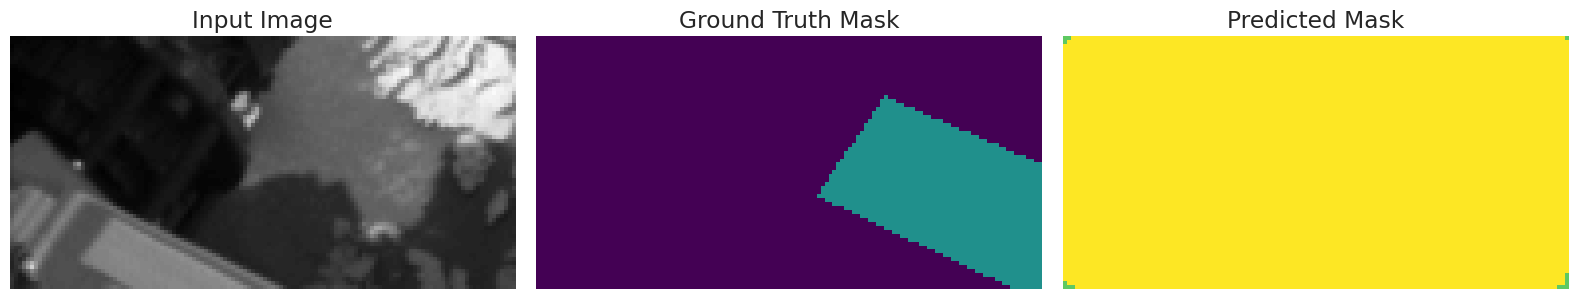

Epoch 1: Learning Rate is 0.001000
35/35 - 80s - 2s/step - accuracy: 0.3868 - loss: 0.0388 - mean_iou: 0.2429 - val_accuracy: 0.0015 - val_loss: 0.3810 - val_mean_iou: 6.6270e-04
Epoch 2/150
Epoch 2: Learning Rate is 0.001000
35/35 - 3s - 73ms/step - accuracy: 0.4126 - loss: 0.0352 - mean_iou: 0.3395 - val_accuracy: 0.1979 - val_loss: 0.2099 - val_mean_iou: 0.0656
Epoch 3/150
Epoch 3: Learning Rate is 0.000999
35/35 - 3s - 72ms/step - accuracy: 0.4690 - loss: 0.0299 - mean_iou: 0.3978 - val_accuracy: 0.1979 - val_loss: 0.2636 - val_mean_iou: 0.0656
Epoch 4/150
Epoch 4: Learning Rate is 0.000998
35/35 - 2s - 71ms/step - accuracy: 0.4596 - loss: 0.0275 - mean_iou: 0.3874 - val_accuracy: 0.1979 - val_loss: 0.2264 - val_mean_iou: 0.0656
Epoch 5/150
Epoch 5: Learning Rate is 0.000997
35/35 - 3s - 72ms/step - accuracy: 0.4935 - loss: 0.0242 - mean_iou: 0.4276 - val_accuracy: 0.1979 - val_loss: 0.1856 - val_mean_iou: 0.0656
Epoch 6/150
Epoch 6: Learning Rate is 0.000996
35/35 - 3s - 72ms/step

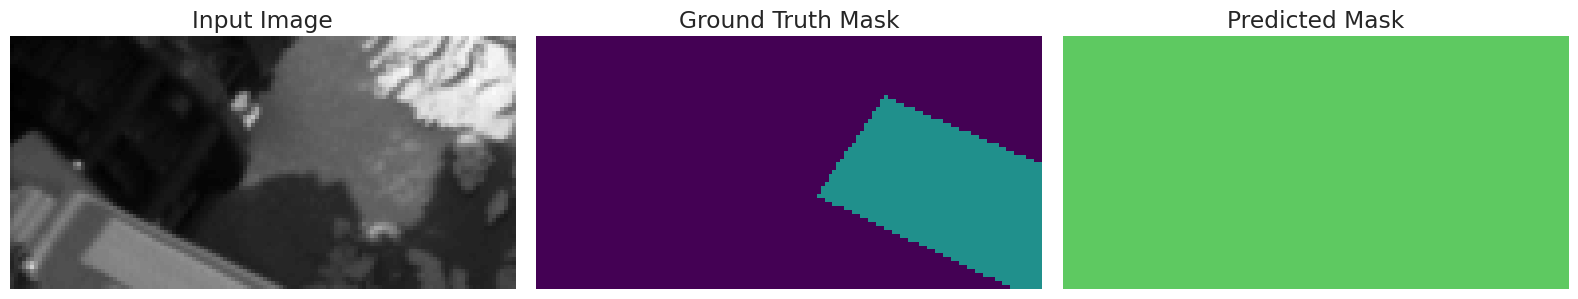

Epoch 11: Learning Rate is 0.000986
35/35 - 3s - 86ms/step - accuracy: 0.5470 - loss: 0.0190 - mean_iou: 0.4906 - val_accuracy: 0.2048 - val_loss: 0.1303 - val_mean_iou: 0.0757
Epoch 12/150
Epoch 12: Learning Rate is 0.000984
35/35 - 2s - 71ms/step - accuracy: 0.5643 - loss: 0.0181 - mean_iou: 0.5119 - val_accuracy: 0.2299 - val_loss: 0.0820 - val_mean_iou: 0.1050
Epoch 13/150
Epoch 13: Learning Rate is 0.000981
35/35 - 3s - 73ms/step - accuracy: 0.5495 - loss: 0.0181 - mean_iou: 0.4984 - val_accuracy: 0.2985 - val_loss: 0.0545 - val_mean_iou: 0.1667
Epoch 14/150
Epoch 14: Learning Rate is 0.000978
35/35 - 3s - 73ms/step - accuracy: 0.5746 - loss: 0.0159 - mean_iou: 0.5264 - val_accuracy: 0.3346 - val_loss: 0.0371 - val_mean_iou: 0.2060
Epoch 15/150
Epoch 15: Learning Rate is 0.000975
35/35 - 3s - 74ms/step - accuracy: 0.5760 - loss: 0.0153 - mean_iou: 0.5305 - val_accuracy: 0.3824 - val_loss: 0.0357 - val_mean_iou: 0.2586
Epoch 16/150
Epoch 16: Learning Rate is 0.000971
35/35 - 3s - 7

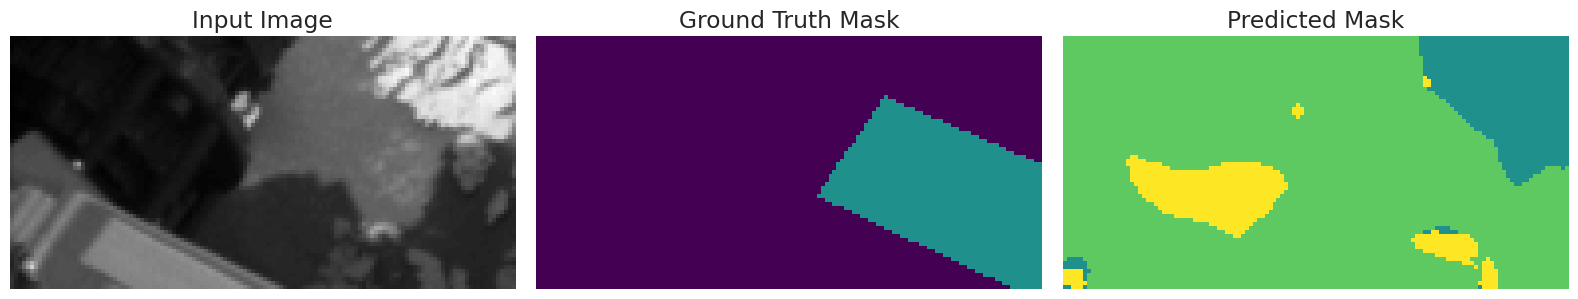

Epoch 21: Learning Rate is 0.000951
35/35 - 3s - 86ms/step - accuracy: 0.5971 - loss: 0.0132 - mean_iou: 0.5627 - val_accuracy: 0.5628 - val_loss: 0.0167 - val_mean_iou: 0.4752
Epoch 22/150
Epoch 22: Learning Rate is 0.000946
35/35 - 2s - 71ms/step - accuracy: 0.6089 - loss: 0.0120 - mean_iou: 0.5864 - val_accuracy: 0.5447 - val_loss: 0.0172 - val_mean_iou: 0.4461
Epoch 23/150
Epoch 23: Learning Rate is 0.000941
35/35 - 3s - 73ms/step - accuracy: 0.6048 - loss: 0.0122 - mean_iou: 0.5809 - val_accuracy: 0.5786 - val_loss: 0.0146 - val_mean_iou: 0.4952
Epoch 24/150
Epoch 24: Learning Rate is 0.000936
35/35 - 3s - 72ms/step - accuracy: 0.6184 - loss: 0.0115 - mean_iou: 0.6043 - val_accuracy: 0.4059 - val_loss: 0.0254 - val_mean_iou: 0.2974
Epoch 25/150
Epoch 25: Learning Rate is 0.000930
35/35 - 3s - 72ms/step - accuracy: 0.6143 - loss: 0.0117 - mean_iou: 0.5915 - val_accuracy: 0.4300 - val_loss: 0.0295 - val_mean_iou: 0.3282
Epoch 26/150
Epoch 26: Learning Rate is 0.000925
35/35 - 2s - 7

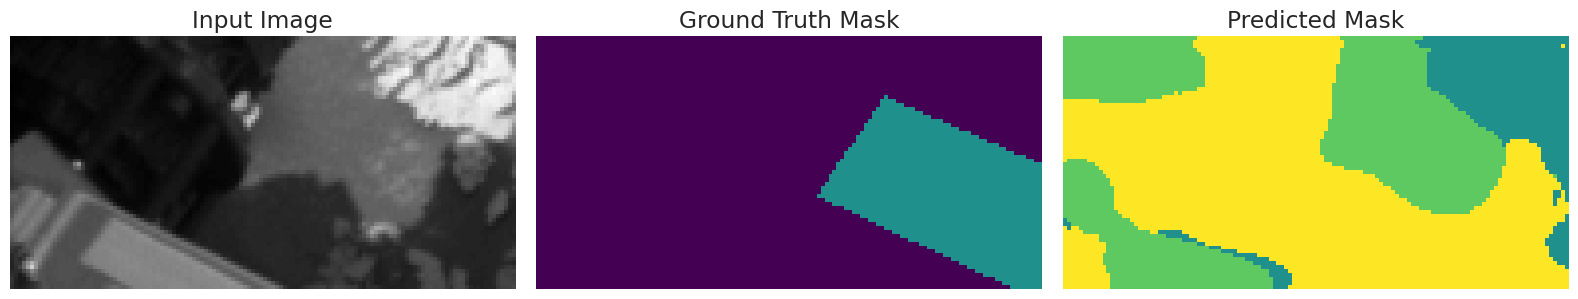

Epoch 31: Learning Rate is 0.000894
35/35 - 3s - 84ms/step - accuracy: 0.6346 - loss: 0.0090 - mean_iou: 0.6577 - val_accuracy: 0.4610 - val_loss: 0.0236 - val_mean_iou: 0.3617
Epoch 32/150
Epoch 32: Learning Rate is 0.000887
35/35 - 2s - 71ms/step - accuracy: 0.6390 - loss: 0.0083 - mean_iou: 0.6677 - val_accuracy: 0.5061 - val_loss: 0.0236 - val_mean_iou: 0.4197
Epoch 33/150
Epoch 33: Learning Rate is 0.000881
35/35 - 2s - 71ms/step - accuracy: 0.6550 - loss: 0.0073 - mean_iou: 0.7186 - val_accuracy: 0.5164 - val_loss: 0.0209 - val_mean_iou: 0.4180
Epoch 34/150
Epoch 34: Learning Rate is 0.000873
35/35 - 3s - 72ms/step - accuracy: 0.6532 - loss: 0.0073 - mean_iou: 0.6995 - val_accuracy: 0.5178 - val_loss: 0.0249 - val_mean_iou: 0.4107
Epoch 35/150
Epoch 35: Learning Rate is 0.000866
35/35 - 3s - 72ms/step - accuracy: 0.6476 - loss: 0.0079 - mean_iou: 0.6868 - val_accuracy: 0.5628 - val_loss: 0.0167 - val_mean_iou: 0.4751
Epoch 36/150
Epoch 36: Learning Rate is 0.000859
35/35 - 3s - 7

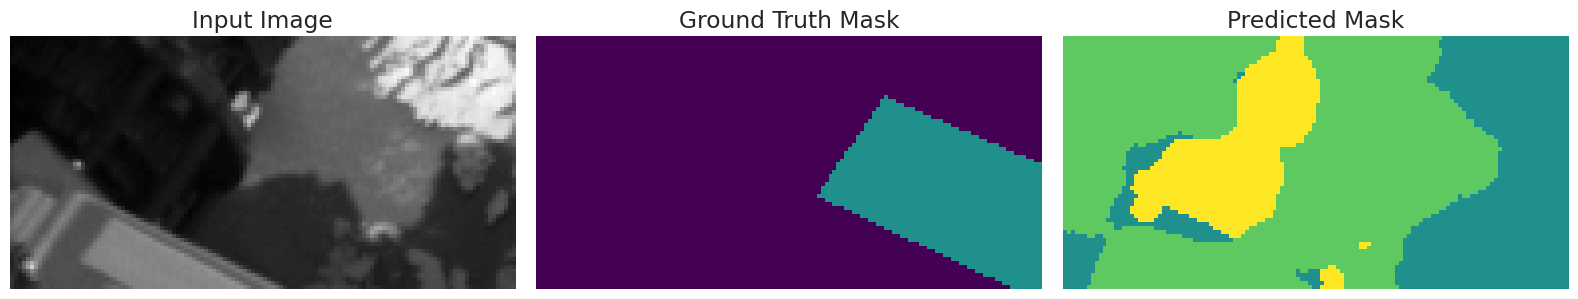

Epoch 41: Learning Rate is 0.000820
35/35 - 3s - 85ms/step - accuracy: 0.6560 - loss: 0.0073 - mean_iou: 0.6888 - val_accuracy: 0.5812 - val_loss: 0.0162 - val_mean_iou: 0.5153
Epoch 42/150
Epoch 42: Learning Rate is 0.000811
35/35 - 3s - 73ms/step - accuracy: 0.6547 - loss: 0.0071 - mean_iou: 0.7077 - val_accuracy: 0.6090 - val_loss: 0.0162 - val_mean_iou: 0.5598
Epoch 43/150
Epoch 43: Learning Rate is 0.000803
35/35 - 3s - 73ms/step - accuracy: 0.6642 - loss: 0.0063 - mean_iou: 0.7369 - val_accuracy: 0.6316 - val_loss: 0.0140 - val_mean_iou: 0.5703
Epoch 44/150
Epoch 44: Learning Rate is 0.000794
35/35 - 3s - 73ms/step - accuracy: 0.6736 - loss: 0.0055 - mean_iou: 0.7819 - val_accuracy: 0.5907 - val_loss: 0.0171 - val_mean_iou: 0.5100
Epoch 45/150
Epoch 45: Learning Rate is 0.000785
35/35 - 2s - 71ms/step - accuracy: 0.6810 - loss: 0.0049 - mean_iou: 0.8111 - val_accuracy: 0.5980 - val_loss: 0.0169 - val_mean_iou: 0.5169
Epoch 46/150
Epoch 46: Learning Rate is 0.000777
35/35 - 2s - 7

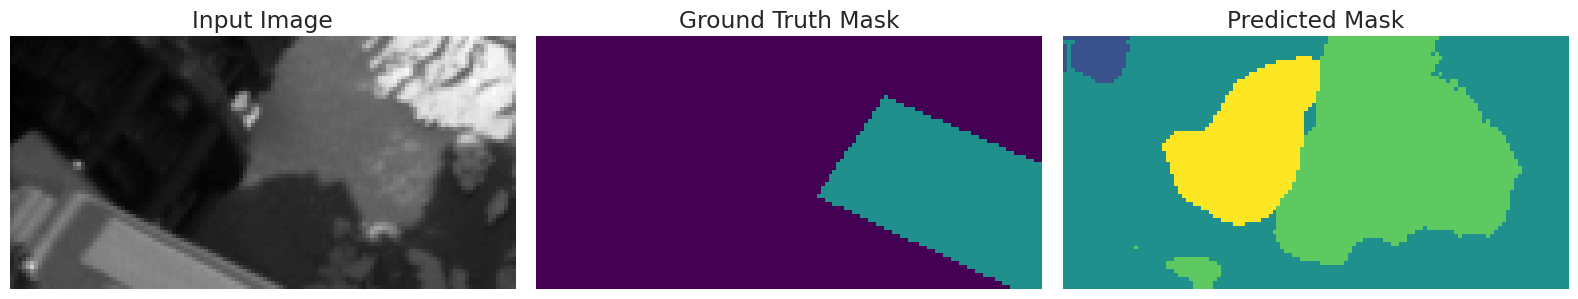

Epoch 51: Learning Rate is 0.000731
35/35 - 3s - 85ms/step - accuracy: 0.6863 - loss: 0.0043 - mean_iou: 0.8387 - val_accuracy: 0.6091 - val_loss: 0.0189 - val_mean_iou: 0.5188
Epoch 52/150
Epoch 52: Learning Rate is 0.000721
35/35 - 2s - 71ms/step - accuracy: 0.6926 - loss: 0.0038 - mean_iou: 0.8701 - val_accuracy: 0.6509 - val_loss: 0.0159 - val_mean_iou: 0.5874
Epoch 53/150
Epoch 53: Learning Rate is 0.000711
35/35 - 3s - 71ms/step - accuracy: 0.6918 - loss: 0.0039 - mean_iou: 0.8680 - val_accuracy: 0.6468 - val_loss: 0.0131 - val_mean_iou: 0.6086
Epoch 54/150
Epoch 54: Learning Rate is 0.000702
35/35 - 3s - 72ms/step - accuracy: 0.6950 - loss: 0.0037 - mean_iou: 0.8454 - val_accuracy: 0.6383 - val_loss: 0.0155 - val_mean_iou: 0.5695
Epoch 55/150
Epoch 55: Learning Rate is 0.000692
35/35 - 2s - 71ms/step - accuracy: 0.6958 - loss: 0.0035 - mean_iou: 0.8679 - val_accuracy: 0.6080 - val_loss: 0.0187 - val_mean_iou: 0.5342
Epoch 56/150
Epoch 56: Learning Rate is 0.000682
35/35 - 2s - 7

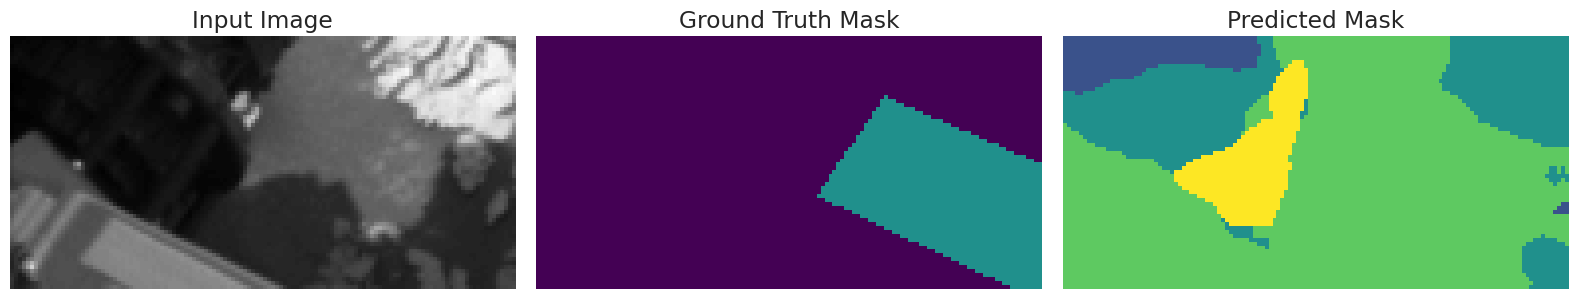

Epoch 61: Learning Rate is 0.000631
35/35 - 3s - 85ms/step - accuracy: 0.7002 - loss: 0.0032 - mean_iou: 0.8824 - val_accuracy: 0.6263 - val_loss: 0.0185 - val_mean_iou: 0.5856
Epoch 62/150
Epoch 62: Learning Rate is 0.000621
35/35 - 3s - 73ms/step - accuracy: 0.7062 - loss: 0.0026 - mean_iou: 0.8989 - val_accuracy: 0.6704 - val_loss: 0.0135 - val_mean_iou: 0.6493
Epoch 63/150
Epoch 63: Learning Rate is 0.000610
35/35 - 3s - 72ms/step - accuracy: 0.7035 - loss: 0.0029 - mean_iou: 0.8950 - val_accuracy: 0.6755 - val_loss: 0.0160 - val_mean_iou: 0.6299
Epoch 64/150
Epoch 64: Learning Rate is 0.000600
35/35 - 3s - 72ms/step - accuracy: 0.7089 - loss: 0.0025 - mean_iou: 0.9001 - val_accuracy: 0.6301 - val_loss: 0.0221 - val_mean_iou: 0.5388
Epoch 65/150
Epoch 65: Learning Rate is 0.000589
35/35 - 2s - 71ms/step - accuracy: 0.7080 - loss: 0.0027 - mean_iou: 0.8972 - val_accuracy: 0.6072 - val_loss: 0.0220 - val_mean_iou: 0.5139
Epoch 66/150
Epoch 66: Learning Rate is 0.000579
35/35 - 2s - 7

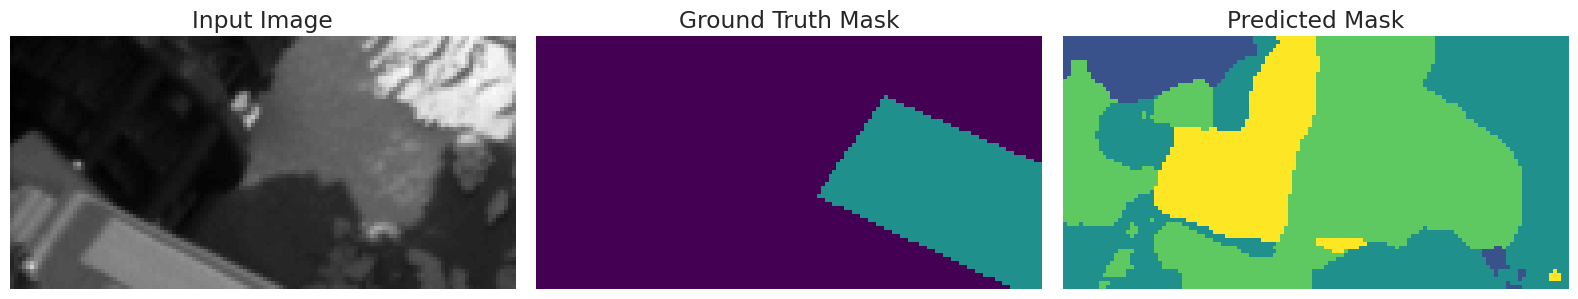

Epoch 71: Learning Rate is 0.000526
35/35 - 3s - 86ms/step - accuracy: 0.7162 - loss: 0.0019 - mean_iou: 0.9341 - val_accuracy: 0.6732 - val_loss: 0.0145 - val_mean_iou: 0.6388
Epoch 72/150
Epoch 72: Learning Rate is 0.000515
35/35 - 2s - 71ms/step - accuracy: 0.7157 - loss: 0.0018 - mean_iou: 0.9328 - val_accuracy: 0.6746 - val_loss: 0.0171 - val_mean_iou: 0.6278
Epoch 73/150
Epoch 73: Learning Rate is 0.000504
35/35 - 3s - 72ms/step - accuracy: 0.7126 - loss: 0.0022 - mean_iou: 0.9307 - val_accuracy: 0.6490 - val_loss: 0.0180 - val_mean_iou: 0.5894
Epoch 74/150
Epoch 74: Learning Rate is 0.000494
35/35 - 3s - 72ms/step - accuracy: 0.7149 - loss: 0.0019 - mean_iou: 0.9286 - val_accuracy: 0.6658 - val_loss: 0.0161 - val_mean_iou: 0.6116
Epoch 75/150
Epoch 75: Learning Rate is 0.000483
35/35 - 3s - 72ms/step - accuracy: 0.7167 - loss: 0.0019 - mean_iou: 0.9426 - val_accuracy: 0.6416 - val_loss: 0.0186 - val_mean_iou: 0.5845
Epoch 76/150
Epoch 76: Learning Rate is 0.000472
35/35 - 2s - 7

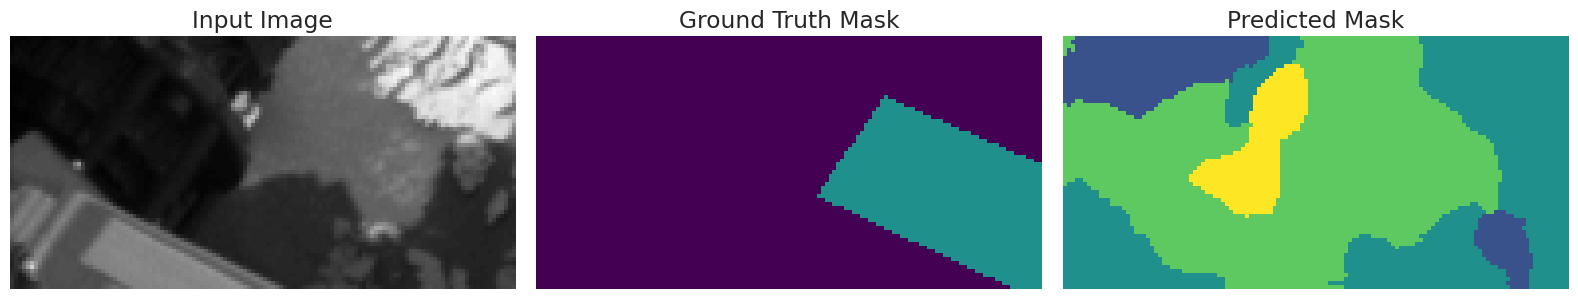

Epoch 81: Learning Rate is 0.000419
35/35 - 3s - 85ms/step - accuracy: 0.7207 - loss: 0.0015 - mean_iou: 0.9509 - val_accuracy: 0.6700 - val_loss: 0.0168 - val_mean_iou: 0.6462
Epoch 82/150
Epoch 82: Learning Rate is 0.000409
35/35 - 3s - 71ms/step - accuracy: 0.7235 - loss: 0.0012 - mean_iou: 0.9564 - val_accuracy: 0.6836 - val_loss: 0.0181 - val_mean_iou: 0.6299
Epoch 83/150
Epoch 83: Learning Rate is 0.000399
35/35 - 3s - 72ms/step - accuracy: 0.7250 - loss: 0.0011 - mean_iou: 0.9637 - val_accuracy: 0.6759 - val_loss: 0.0178 - val_mean_iou: 0.6234
Epoch 84/150
Epoch 84: Learning Rate is 0.000388
35/35 - 3s - 72ms/step - accuracy: 0.7207 - loss: 0.0015 - mean_iou: 0.9522 - val_accuracy: 0.6739 - val_loss: 0.0178 - val_mean_iou: 0.6343
Epoch 85/150
Epoch 85: Learning Rate is 0.000378
35/35 - 3s - 72ms/step - accuracy: 0.7197 - loss: 0.0015 - mean_iou: 0.9543 - val_accuracy: 0.6487 - val_loss: 0.0231 - val_mean_iou: 0.6109
Epoch 86/150
Epoch 86: Learning Rate is 0.000367
35/35 - 2s - 7

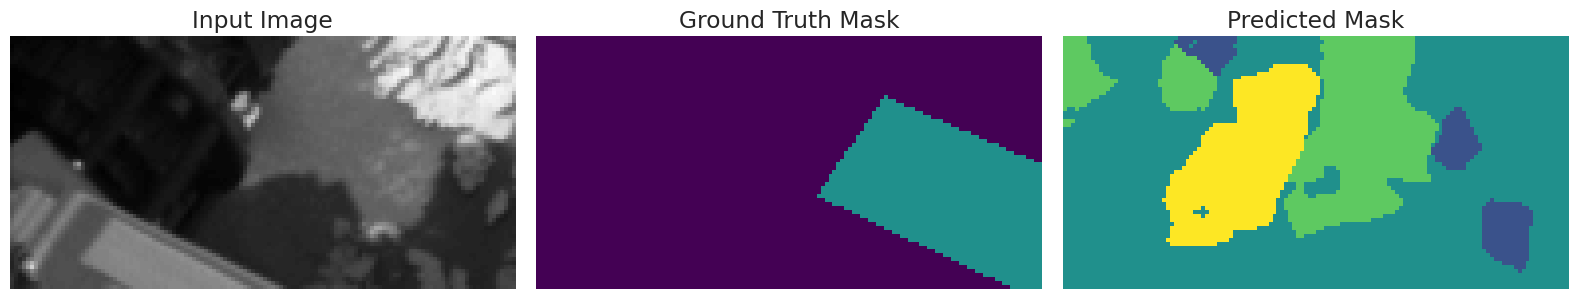

Epoch 91: Learning Rate is 0.000317
35/35 - 3s - 85ms/step - accuracy: 0.7240 - loss: 0.0012 - mean_iou: 0.9610 - val_accuracy: 0.6747 - val_loss: 0.0180 - val_mean_iou: 0.6254
Epoch 92/150
Epoch 92: Learning Rate is 0.000307
35/35 - 3s - 72ms/step - accuracy: 0.7241 - loss: 0.0012 - mean_iou: 0.9631 - val_accuracy: 0.6611 - val_loss: 0.0195 - val_mean_iou: 0.6266
Epoch 93/150
Epoch 93: Learning Rate is 0.000298
35/35 - 3s - 72ms/step - accuracy: 0.7237 - loss: 0.0012 - mean_iou: 0.9627 - val_accuracy: 0.6628 - val_loss: 0.0192 - val_mean_iou: 0.6330
Epoch 94/150
Epoch 94: Learning Rate is 0.000288
35/35 - 3s - 72ms/step - accuracy: 0.7254 - loss: 0.0011 - mean_iou: 0.9678 - val_accuracy: 0.6479 - val_loss: 0.0195 - val_mean_iou: 0.6067
Epoch 95/150
Epoch 95: Learning Rate is 0.000278
35/35 - 3s - 72ms/step - accuracy: 0.7243 - loss: 0.0011 - mean_iou: 0.9639 - val_accuracy: 0.6667 - val_loss: 0.0170 - val_mean_iou: 0.6360
Epoch 96/150
Epoch 96: Learning Rate is 0.000269
35/35 - 2s - 7

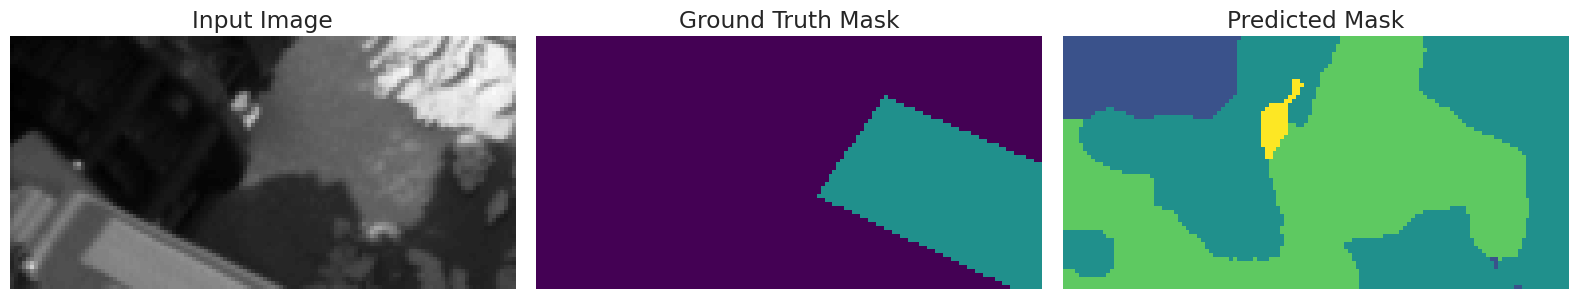

Epoch 101: Learning Rate is 0.000223
35/35 - 3s - 85ms/step - accuracy: 0.7291 - loss: 6.7454e-04 - mean_iou: 0.9782 - val_accuracy: 0.6726 - val_loss: 0.0188 - val_mean_iou: 0.6407
Epoch 102/150
Epoch 102: Learning Rate is 0.000215
35/35 - 3s - 72ms/step - accuracy: 0.7279 - loss: 7.7231e-04 - mean_iou: 0.9730 - val_accuracy: 0.6839 - val_loss: 0.0169 - val_mean_iou: 0.6599
Epoch 103/150
Epoch 103: Learning Rate is 0.000206
35/35 - 3s - 72ms/step - accuracy: 0.7272 - loss: 8.5217e-04 - mean_iou: 0.9731 - val_accuracy: 0.6789 - val_loss: 0.0185 - val_mean_iou: 0.6367
Epoch 104/150
Epoch 104: Learning Rate is 0.000198
35/35 - 3s - 73ms/step - accuracy: 0.7291 - loss: 6.6620e-04 - mean_iou: 0.9766 - val_accuracy: 0.6885 - val_loss: 0.0166 - val_mean_iou: 0.6709
Epoch 105/150
Epoch 105: Learning Rate is 0.000189
35/35 - 3s - 73ms/step - accuracy: 0.7277 - loss: 8.0014e-04 - mean_iou: 0.9710 - val_accuracy: 0.6909 - val_loss: 0.0159 - val_mean_iou: 0.6712
Epoch 106/150
Epoch 106: Learning 

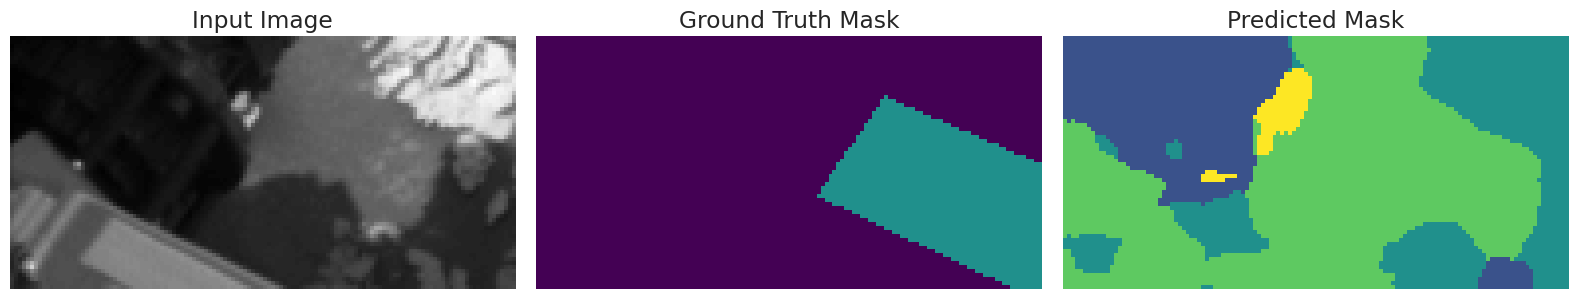

Epoch 111: Learning Rate is 0.000143
35/35 - 3s - 85ms/step - accuracy: 0.7298 - loss: 6.0815e-04 - mean_iou: 0.9790 - val_accuracy: 0.6850 - val_loss: 0.0162 - val_mean_iou: 0.6587
Epoch 112/150
Epoch 112: Learning Rate is 0.000136
35/35 - 3s - 72ms/step - accuracy: 0.7302 - loss: 5.8254e-04 - mean_iou: 0.9789 - val_accuracy: 0.6907 - val_loss: 0.0164 - val_mean_iou: 0.6649
Epoch 113/150
Epoch 113: Learning Rate is 0.000129
35/35 - 3s - 72ms/step - accuracy: 0.7302 - loss: 5.7759e-04 - mean_iou: 0.9812 - val_accuracy: 0.6867 - val_loss: 0.0180 - val_mean_iou: 0.6552
Epoch 114/150
Epoch 114: Learning Rate is 0.000122
35/35 - 2s - 71ms/step - accuracy: 0.7298 - loss: 6.1350e-04 - mean_iou: 0.9795 - val_accuracy: 0.6824 - val_loss: 0.0171 - val_mean_iou: 0.6579
Epoch 115/150
Epoch 115: Learning Rate is 0.000115
35/35 - 2s - 71ms/step - accuracy: 0.7294 - loss: 6.5029e-04 - mean_iou: 0.9793 - val_accuracy: 0.6817 - val_loss: 0.0179 - val_mean_iou: 0.6548
Epoch 116/150
Epoch 116: Learning 

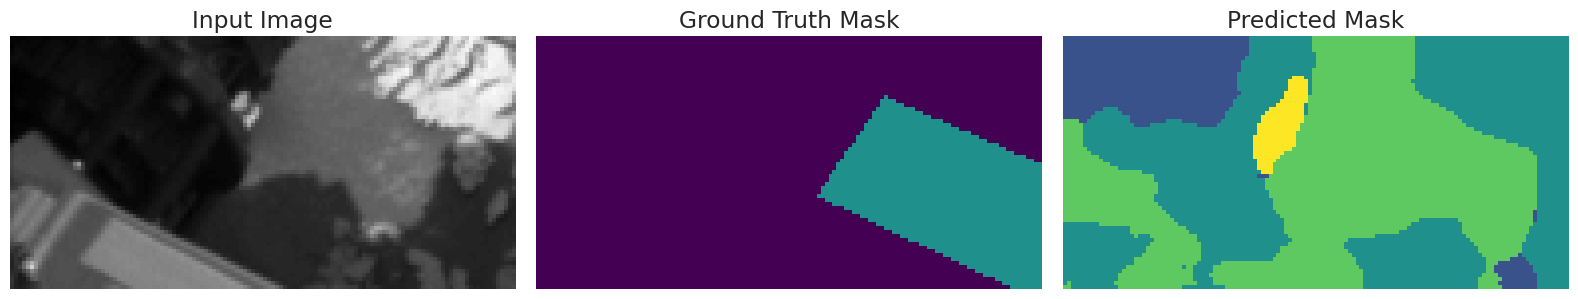

Epoch 121: Learning Rate is 0.000079
35/35 - 3s - 85ms/step - accuracy: 0.7307 - loss: 5.0313e-04 - mean_iou: 0.9827 - val_accuracy: 0.6892 - val_loss: 0.0161 - val_mean_iou: 0.6718
Epoch 122/150
Epoch 122: Learning Rate is 0.000074
35/35 - 3s - 72ms/step - accuracy: 0.7310 - loss: 4.7867e-04 - mean_iou: 0.9844 - val_accuracy: 0.6853 - val_loss: 0.0168 - val_mean_iou: 0.6651
Epoch 123/150
Epoch 123: Learning Rate is 0.000069
35/35 - 3s - 73ms/step - accuracy: 0.7305 - loss: 5.1750e-04 - mean_iou: 0.9822 - val_accuracy: 0.6922 - val_loss: 0.0156 - val_mean_iou: 0.6791
Epoch 124/150
Epoch 124: Learning Rate is 0.000064
35/35 - 2s - 71ms/step - accuracy: 0.7303 - loss: 5.5624e-04 - mean_iou: 0.9794 - val_accuracy: 0.6921 - val_loss: 0.0154 - val_mean_iou: 0.6778
Epoch 125/150
Epoch 125: Learning Rate is 0.000059
35/35 - 3s - 72ms/step - accuracy: 0.7303 - loss: 5.6334e-04 - mean_iou: 0.9814 - val_accuracy: 0.6900 - val_loss: 0.0162 - val_mean_iou: 0.6720
Epoch 126/150
Epoch 126: Learning 

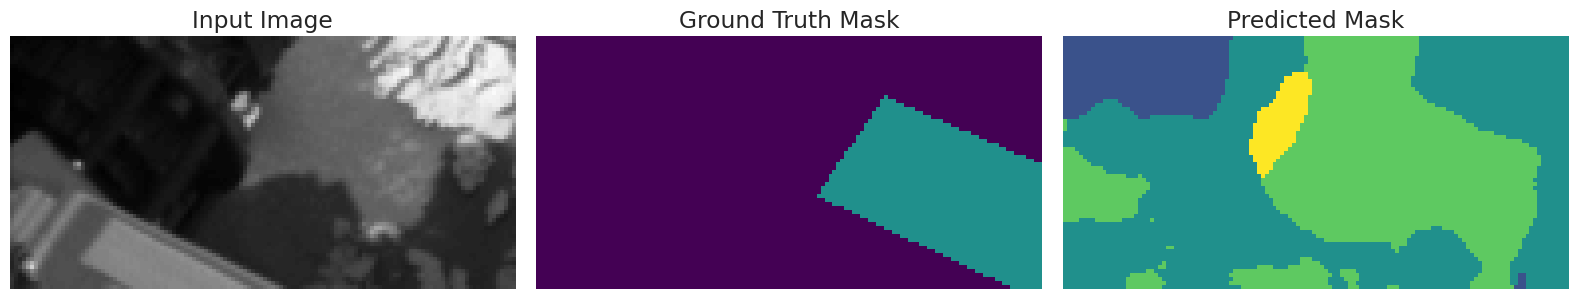

Epoch 131: Learning Rate is 0.000035
35/35 - 3s - 85ms/step - accuracy: 0.7315 - loss: 4.6468e-04 - mean_iou: 0.9856 - val_accuracy: 0.6922 - val_loss: 0.0154 - val_mean_iou: 0.6766
Epoch 132/150
Epoch 132: Learning Rate is 0.000032
35/35 - 3s - 72ms/step - accuracy: 0.7302 - loss: 6.1022e-04 - mean_iou: 0.9823 - val_accuracy: 0.6894 - val_loss: 0.0154 - val_mean_iou: 0.6724
Epoch 133/150
Epoch 133: Learning Rate is 0.000029
35/35 - 2s - 71ms/step - accuracy: 0.7316 - loss: 4.4474e-04 - mean_iou: 0.9831 - val_accuracy: 0.6911 - val_loss: 0.0159 - val_mean_iou: 0.6765
Epoch 134/150
Epoch 134: Learning Rate is 0.000026
35/35 - 2s - 71ms/step - accuracy: 0.7321 - loss: 4.0229e-04 - mean_iou: 0.9879 - val_accuracy: 0.6919 - val_loss: 0.0160 - val_mean_iou: 0.6779
Epoch 135/150
Epoch 135: Learning Rate is 0.000023
35/35 - 3s - 72ms/step - accuracy: 0.7323 - loss: 3.4968e-04 - mean_iou: 0.9857 - val_accuracy: 0.6928 - val_loss: 0.0163 - val_mean_iou: 0.6792
Epoch 136/150
Epoch 136: Learning 

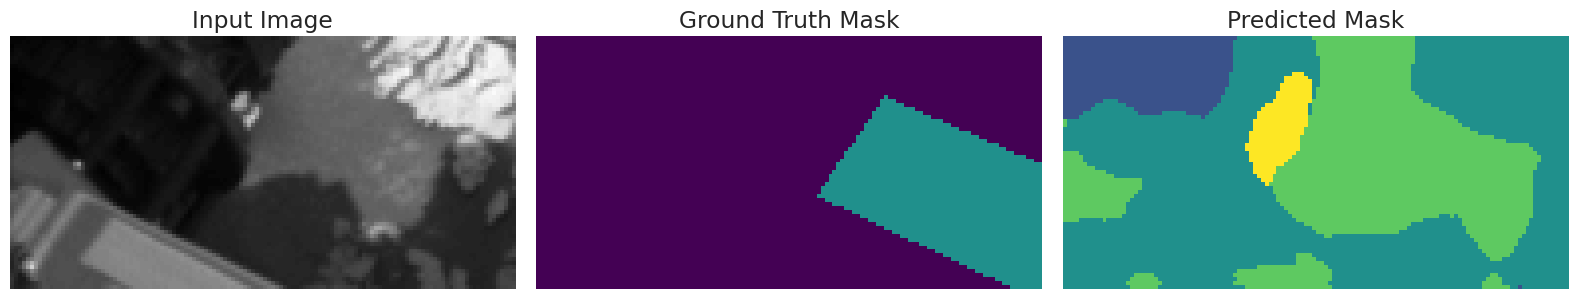

Epoch 141: Learning Rate is 0.000013
35/35 - 3s - 86ms/step - accuracy: 0.7323 - loss: 3.6993e-04 - mean_iou: 0.9865 - val_accuracy: 0.6925 - val_loss: 0.0164 - val_mean_iou: 0.6807
Epoch 142/150
Epoch 142: Learning Rate is 0.000012
35/35 - 3s - 72ms/step - accuracy: 0.7316 - loss: 4.3503e-04 - mean_iou: 0.9850 - val_accuracy: 0.6926 - val_loss: 0.0161 - val_mean_iou: 0.6809
Epoch 143/150
Epoch 143: Learning Rate is 0.000011
35/35 - 3s - 71ms/step - accuracy: 0.7314 - loss: 4.4267e-04 - mean_iou: 0.9844 - val_accuracy: 0.6922 - val_loss: 0.0161 - val_mean_iou: 0.6800
Epoch 144/150
Epoch 144: Learning Rate is 0.000010
35/35 - 3s - 72ms/step - accuracy: 0.7316 - loss: 4.5158e-04 - mean_iou: 0.9856 - val_accuracy: 0.6919 - val_loss: 0.0163 - val_mean_iou: 0.6780
Epoch 145/150
Epoch 145: Learning Rate is 0.000010
35/35 - 2s - 71ms/step - accuracy: 0.7321 - loss: 3.9135e-04 - mean_iou: 0.9852 - val_accuracy: 0.6924 - val_loss: 0.0162 - val_mean_iou: 0.6791
Epoch 146/150
Epoch 146: Learning 

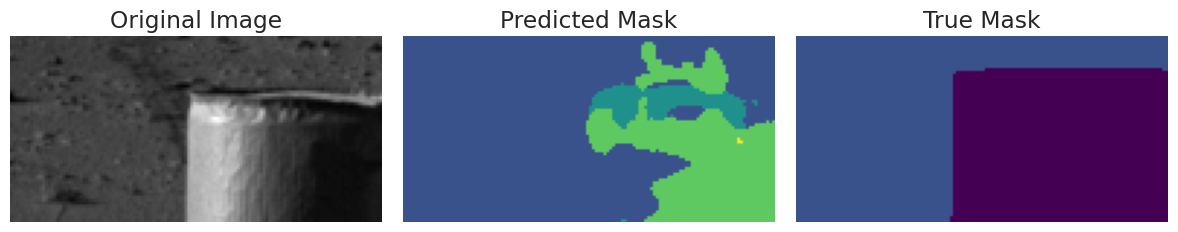

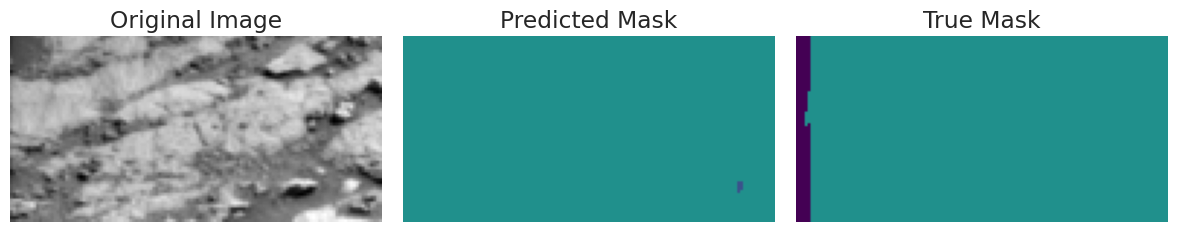

Plotting 1 test images...


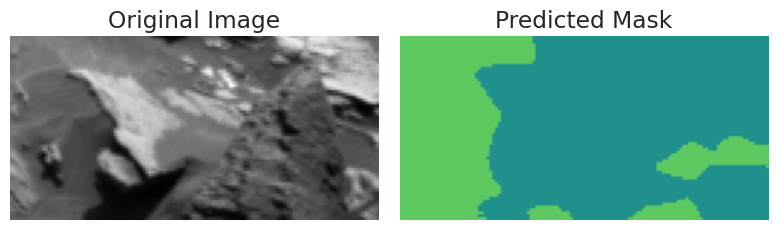


--------------------------------------------------



[
    {
        'BATCH_SIZE': 64,
        'MODEL': 'unet_3_plus',
        'NUM_LEVELS': 4,
        'LOSS': 'cce',
        'LOSS_WEIGHTS': [1],
        'CLASS_WEIGHTS': [[0.0, 0.025, 0.035, 0.04, 0.88]],
        'EARLY_STOPPING': True,
        'PATIENCE': 40,
        'EPOCHS': 150,
        'LR_SCHEDULER': 'cosine',
        'LEARNING_RATE': 0.001,
        'LR_PATIENCE': 25,
        'DUPLICATE': 4,
        'AUGMENTATION': [
            <RandomGaussianBlur name=random_gaussian_blur, built=True>,
            <GaussianNoise name=gaussian_noise, built=True>,
            <RandomFlip name=random_flip, built=True>
        ],
        'MODEL_VERBOSE': 2,
        'FULL_VERBOSE': 1,
        'VIZ_CALLBACK': 10,
        'PLOT_VAL': 2,
        'PLOT_TEST': 1,
        'PLOT_HISTORY': False,
        'SAVE_MODEL': False,
        'SUBMISSION': False,
        'DESCRIPTION': 'UNet 3+ with 4 levels',
        'results': {
            'best_epoch': 139,
            'final_val_loss': 0.0162,
            'final_val_accuracy': 69.25,
            'final_val_meanIoU': 68.2,
            'final_precision': 52.89,
            'final_recall': 69.25,
            'final_f1': 59.88,
            'classes': [
                {
                    'class_index': 0,
                    'class_count': 1008933,
                    'class_pred': 0,
                    'class_accuracy': 0.0,
                    'class_meanIoU': 0.0,
                    'class_precision': 0.0,
                    'class_recall': 0.0,
                    'class_f1_score': 0.0
                },
                {
                    'class_index': 1,
                    'class_count': 1425376,
                    'class_pred': 1739741,
                    'class_accuracy': 93.93,
                    'class_meanIoU': 73.31,
                    'class_precision': 76.96,
                    'class_recall': 93.93,
                    'class_f1_score': 84.6
                },
                {
                    'class_index': 2,
                    'class_count': 852217,
                    'class_pred': 1270007,
                    'class_accuracy': 89.39,
                    'class_meanIoU': 55.99,
                    'class_precision': 59.98,
                    'class_recall': 89.39,
                    'class_f1_score': 71.79
                },
                {
                    'class_index': 3,
                    'class_count': 812032,
                    'class_pred': 1068624,
                    'class_accuracy': 91.16,
                    'class_meanIoU': 64.91,
                    'class_precision': 69.27,
                    'class_recall': 91.16,
                    'class_f1_score': 78.72
                },
                {
                    'class_index': 4,
                    'class_count': 5634,
                    'class_pred': 25820,
                    'class_accuracy': 25.54,
                    'class_meanIoU': 4.79,
                    'class_precision': 5.57,
                    'class_recall': 25.54,
                    'class_f1_score': 9.15
                }
            ]
        }
    }
]

In [ ]:
for config in configs:
    # rprint(config)
    v = str(int(v) + 1)
    version = prefix + "." + v

    ########################### APPLY CONFIGURATION ###########################
    BATCH_SIZE =      config["BATCH_SIZE"]
    LR_SCHEDULER =    config["LR_SCHEDULER"]
    LEARNING_RATE =   config["LEARNING_RATE"]
    PATIENCE =        config["PATIENCE"]
    LR_PATIENCE =     config["LR_PATIENCE"]
    EPOCHS =          config["EPOCHS"]
    DUPLICATE =       config["DUPLICATE"]
    MODEL =           config["MODEL"]
    NUM_LEVELS =      config["NUM_LEVELS"]
    LOSS =            config["LOSS"]
    LOSS_WEIGHTS =    config["LOSS_WEIGHTS"]
    CLASS_WEIGHTS =   config["CLASS_WEIGHTS"]
    AUGMENTATION =    config["AUGMENTATION"]
    MODEL_VERBOSE =   config["MODEL_VERBOSE"]
    FULL_VERBOSE =    config["FULL_VERBOSE"]
    EARLY_STOPPING =  config["EARLY_STOPPING"]
    VIZ_CALLBACK =    config["VIZ_CALLBACK"]
    PLOT_VAL =        config["PLOT_VAL"]
    PLOT_TEST =       config["PLOT_TEST"]
    PLOT_HISTORY =    config["PLOT_HISTORY"]
    SAVE_MODEL =      config["SAVE_MODEL"]
    SUBMISSION =      config["SUBMISSION"]
    NUM_CLASSES =     len(class_dict)

    # Change the name
    print(f'{area}: {MODEL}')
    model_name = "M" + "_" + MODEL

    ########################### LOAD and PREPROCESS DATA #######################

    # Load the training data
    data = np.load("./mars_cleaned.npz")
    training_set = data["training_set"]
    X_train_val = training_set[:, 0]
    y_train_val = training_set[:, 1]

    # Reshape the data
    X_train_val = X_train_val[..., np.newaxis] / 255.0

    # Split the data into training, validation, and test sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.2, random_state=seed
    )

    ######################### BIG ROCK DUPLICATION #############################

    # Duplicate the big rock instances
    if DUPLICATE is not None:
        indices_with_class_4 = [i for i, mask in enumerate(y_train) if np.any(mask == 4)]
        for _ in range(DUPLICATE):
            # Append the images and labels that contain class 4 to the training set
            X_train = np.concatenate((X_train, X_train[indices_with_class_4]), axis=0)
            y_train = np.concatenate((y_train, y_train[indices_with_class_4]), axis=0)
        class_counts = np.array([(y_train == c).any(axis=(1, 2)).sum() for c in range(NUM_CLASSES)])
    input_shape = X_train.shape[1:]
    # print("\n".join(f"Class {i} ({class_dict[i]}): {class_counts[i]}" for i in range(NUM_CLASSES)))

    ######################### ONEHOT ENCODING ##################################
    y_train = tf.one_hot(tf.cast(y_train, tf.int32), depth=NUM_CLASSES)
    y_val = tf.one_hot(tf.cast(y_val, tf.int32), depth=NUM_CLASSES)

    ########################### BUILD DATASET ##################################
    train_dataset = make_dataset(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True, augment=True, augmentation=AUGMENTATION, seed=seed)
    val_dataset = make_dataset(X_val, y_val, batch_size=BATCH_SIZE, shuffle=False)

    ########################### LOSSES #########################################
    # sk_class_weights = compute_class_weights(y_train)
    # CLASS_WEIGHTS[-1] = sk_class_weights
    loss_fns = get_loss_function(LOSS, weights=LOSS_WEIGHTS, class_weights=CLASS_WEIGHTS)

    ########################### CALLBACKS ######################################
    callbacks = []
    if EARLY_STOPPING:
        callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_mean_iou', mode='max', patience=PATIENCE, restore_best_weights=True))
    if VIZ_CALLBACK is not None:
        idx = random.randint(0,len(X_val))
        callbacks.append(VizCallback(X_val[idx], y_val[idx], colormap,frequency=VIZ_CALLBACK))

    ########################## SET LEARNING RATE ###############################
    steps_per_epoch = (len(X_train) // BATCH_SIZE )
    if LR_SCHEDULER == "reduce":
        callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mean_iou', mode='max', factor=0.5, patience=LR_PATIENCE, min_lr=1e-6))
    elif LR_SCHEDULER == "cosine":
        learning_rate = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=LEARNING_RATE,decay_steps=EPOCHS*steps_per_epoch,alpha=1e-2)
        callbacks.append(LearningRateLogger())
    elif LR_SCHEDULER == "cosinerestart":
        learning_rate = tf.keras.optimizers.schedules.CosineDecayRestarts(initial_learning_rate=LEARNING_RATE,first_decay_steps=30*steps_per_epoch,t_mul=1.5, m_mul=0.9, alpha=1e-3)
        callbacks.append(LearningRateLogger())
    else:
        learning_rate = LEARNING_RATE

    ########################## SET MODEL #######################################
    model = get_model(MODEL, input_shape=input_shape, num_classes=NUM_CLASSES, seed=seed, num_levels=NUM_LEVELS)
    print(f"Built model: {model.name}")
    if FULL_VERBOSE > 2:
        model.summary()

    ########################### COMPILE MODEL ##################################
    # Compile Model
    model.compile(
        loss=loss_fns,
        optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate),
        metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
    )

    ###########################  FIT THE MODEL #################################
    history = model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, callbacks=callbacks, verbose=MODEL_VERBOSE).history
    histories.append(history)
    if PLOT_HISTORY:
        plot_history(history)

    ########################### EVALUATE #######################################
    y_true = np.array(np.argmax(y_val.numpy(), axis=-1).flatten())
    y_pred = np.array(np.argmax(model.predict(X_val, verbose=0), axis=-1).flatten())

    ######################### OVERALL PERFORMANCE ##############################
    best_epoch = history['val_mean_iou'].index(max(history['val_mean_iou'])) + 1
    final_val_meanIoU = round(history['val_mean_iou'][best_epoch - 1] * 100, 2)
    final_val_accuracy = round(history['val_accuracy'][best_epoch - 1] * 100, 2)
    final_val_loss = round(history['val_loss'][best_epoch - 1], 4)

    print(f'Best epoch:     {best_epoch}')
    print(f'Final val loss:   {final_val_loss:6.3f}')
    print(f'Final accuracy:   {final_val_accuracy:6.2f}%')
    print(f'Final meanIoU:    {final_val_meanIoU:6.2f}%')

    ###################### ADDITIONAL METRICS ##################################
    result_entry = {
        "best_epoch": best_epoch,
        "final_val_loss": final_val_loss,
        "final_val_accuracy": final_val_accuracy,
        "final_val_meanIoU": final_val_meanIoU,
    }

    additonal_metrics(result_entry, y_true, y_pred, verbose=FULL_VERBOSE)

    ########################### SAVE RESULTS ###################################
    config["results"] = result_entry

    ########################### PLOT VAL #######################################
    if PLOT_VAL is not None:
        print("Plotting " + str(PLOT_VAL) + " validation images...")
        plot_triptychs(X_val, y_val, model, num_samples=PLOT_VAL, colormap=colormap)

    ########################### SAVE MODEL #####################################
    if SAVE_MODEL == True:
        # Save the trained model to a file with the accuracy included in the filename
        model_filename = model_name + "_" + version + "_"+str(final_val_meanIoU)+'.keras'
        model.save(model_filename)
        config["model_filename"] = model_filename
        print(f"Model saved as {model_filename}")

    ########################### INFERENCE ######################################
    preds = model.predict(test_dataset, verbose=0)
    preds = np.argmax(preds, axis=-1)
    # print(f"Predictions shape: {preds.shape}")

    ########################### PLOT TEST #######################################
    if PLOT_TEST is not None:
        print("Plotting " + str(PLOT_TEST) + " test images...")
        plot_triptychs(X_test, None, model, num_samples=PLOT_TEST, colormap=colormap)

    ########################### CREATE SUBMISSION ###############################
    if SUBMISSION:
        # Save predictions in the required format
        timestep_str = datetime.now().strftime("%d%m_%H%M")
        submission_filename = f"{model_name}_{version}_{str(final_val_meanIoU)}_{timestep_str}.csv"
        submission_df = y_to_df(preds)
        submission_df.to_csv(submission_filename, index=False)
        config["submission_filename"] = submission_filename
        print("Submission file created and downloaded as:", submission_filename)

    ########################## GARBAGE COLLECTION ##############################

    # Delete the model to free up resources
    outputs.append(config)
    del model
    print("\n" + "-" * 50 + "\n")
    # tf.keras.backend.clear_session()
rprint(outputs)

## Background Binary Classifier


Epoch 1/150


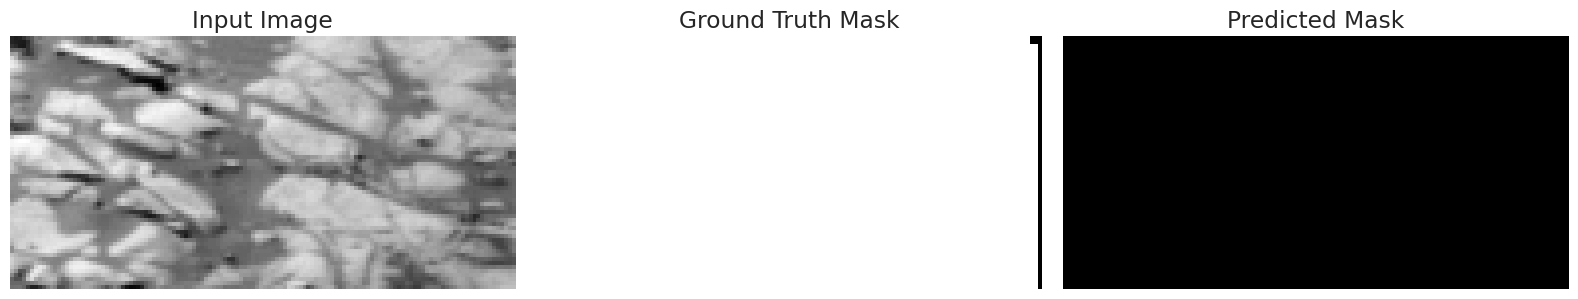

32/32 - 88s - 3s/step - accuracy: 0.7610 - loss: 0.5668 - mean_iou: 0.4647 - val_accuracy: 0.2458 - val_loss: 12.1028 - val_mean_iou: 0.1229
Epoch 2/150
32/32 - 1s - 33ms/step - accuracy: 0.7960 - loss: 0.4740 - mean_iou: 0.5191 - val_accuracy: 0.3536 - val_loss: 1.8589 - val_mean_iou: 0.2144
Epoch 3/150
32/32 - 1s - 32ms/step - accuracy: 0.8097 - loss: 0.4560 - mean_iou: 0.5485 - val_accuracy: 0.7542 - val_loss: 0.8344 - val_mean_iou: 0.3771
Epoch 4/150
32/32 - 1s - 28ms/step - accuracy: 0.8139 - loss: 0.4447 - mean_iou: 0.5576 - val_accuracy: 0.2458 - val_loss: 10.4345 - val_mean_iou: 0.1229
Epoch 5/150
32/32 - 1s - 28ms/step - accuracy: 0.8162 - loss: 0.4411 - mean_iou: 0.5659 - val_accuracy: 0.7526 - val_loss: 0.5582 - val_mean_iou: 0.3839
Epoch 6/150
32/32 - 1s - 28ms/step - accuracy: 0.8230 - loss: 0.4270 - mean_iou: 0.5804 - val_accuracy: 0.7542 - val_loss: 0.6724 - val_mean_iou: 0.3771
Epoch 7/150
32/32 - 1s - 28ms/step - accuracy: 0.8263 - loss: 0.4139 - mean_iou: 0.5899 - val

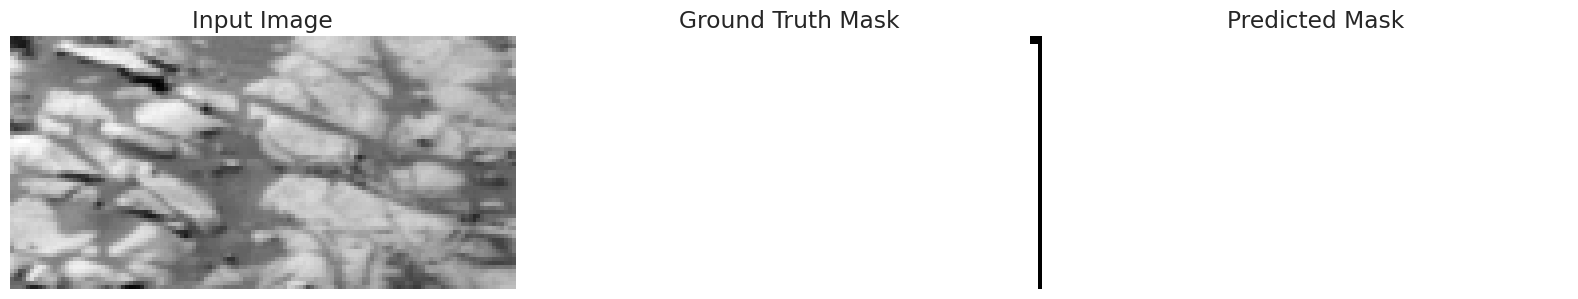

32/32 - 1s - 47ms/step - accuracy: 0.8364 - loss: 0.3960 - mean_iou: 0.6132 - val_accuracy: 0.7577 - val_loss: 0.6107 - val_mean_iou: 0.3906
Epoch 12/150
32/32 - 1s - 28ms/step - accuracy: 0.8400 - loss: 0.3840 - mean_iou: 0.6193 - val_accuracy: 0.7544 - val_loss: 0.9707 - val_mean_iou: 0.3776
Epoch 13/150
32/32 - 1s - 28ms/step - accuracy: 0.8482 - loss: 0.3653 - mean_iou: 0.6437 - val_accuracy: 0.7543 - val_loss: 0.8798 - val_mean_iou: 0.3773
Epoch 14/150
32/32 - 1s - 28ms/step - accuracy: 0.8562 - loss: 0.3534 - mean_iou: 0.6592 - val_accuracy: 0.7564 - val_loss: 0.6854 - val_mean_iou: 0.3858
Epoch 15/150
32/32 - 1s - 28ms/step - accuracy: 0.8639 - loss: 0.3324 - mean_iou: 0.6770 - val_accuracy: 0.7566 - val_loss: 0.7586 - val_mean_iou: 0.3955
Epoch 16/150
32/32 - 1s - 33ms/step - accuracy: 0.8671 - loss: 0.3256 - mean_iou: 0.6841 - val_accuracy: 0.7670 - val_loss: 0.6462 - val_mean_iou: 0.4293
Epoch 17/150
32/32 - 1s - 28ms/step - accuracy: 0.8703 - loss: 0.3169 - mean_iou: 0.6937 

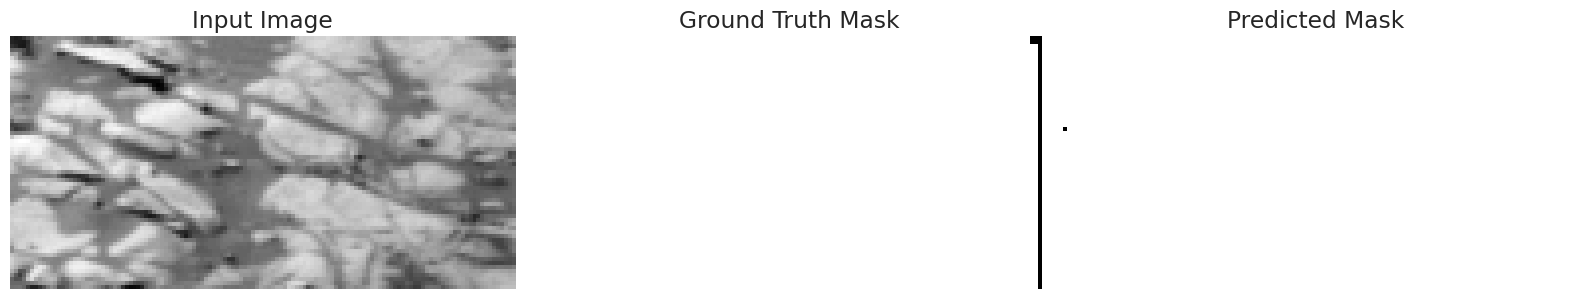

32/32 - 1s - 42ms/step - accuracy: 0.8916 - loss: 0.2693 - mean_iou: 0.7410 - val_accuracy: 0.7914 - val_loss: 0.5208 - val_mean_iou: 0.5702
Epoch 22/150
32/32 - 1s - 31ms/step - accuracy: 0.8906 - loss: 0.2661 - mean_iou: 0.7388 - val_accuracy: 0.8010 - val_loss: 0.6086 - val_mean_iou: 0.5642
Epoch 23/150
32/32 - 1s - 29ms/step - accuracy: 0.8923 - loss: 0.2610 - mean_iou: 0.7416 - val_accuracy: 0.7496 - val_loss: 0.6695 - val_mean_iou: 0.5381
Epoch 24/150
32/32 - 1s - 31ms/step - accuracy: 0.8974 - loss: 0.2525 - mean_iou: 0.7536 - val_accuracy: 0.8085 - val_loss: 0.6441 - val_mean_iou: 0.5636
Epoch 25/150
32/32 - 1s - 31ms/step - accuracy: 0.9023 - loss: 0.2409 - mean_iou: 0.7646 - val_accuracy: 0.8217 - val_loss: 0.6316 - val_mean_iou: 0.5804
Epoch 26/150
32/32 - 1s - 28ms/step - accuracy: 0.9066 - loss: 0.2298 - mean_iou: 0.7743 - val_accuracy: 0.7991 - val_loss: 0.6428 - val_mean_iou: 0.5424
Epoch 27/150
32/32 - 1s - 28ms/step - accuracy: 0.9094 - loss: 0.2231 - mean_iou: 0.7804 

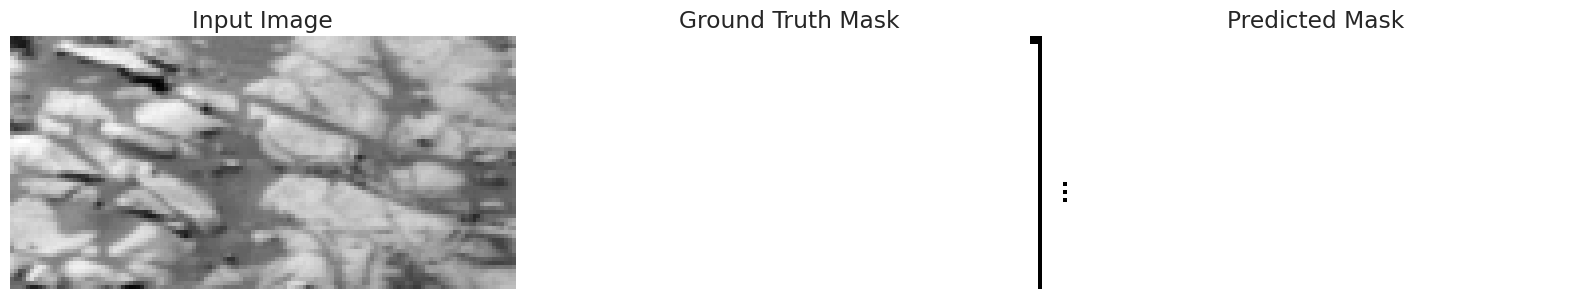

32/32 - 1s - 42ms/step - accuracy: 0.9243 - loss: 0.1898 - mean_iou: 0.8136 - val_accuracy: 0.8165 - val_loss: 0.6101 - val_mean_iou: 0.5964
Epoch 32/150
32/32 - 1s - 28ms/step - accuracy: 0.9240 - loss: 0.1905 - mean_iou: 0.8120 - val_accuracy: 0.8076 - val_loss: 0.5791 - val_mean_iou: 0.5949
Epoch 33/150
32/32 - 1s - 28ms/step - accuracy: 0.9287 - loss: 0.1769 - mean_iou: 0.8238 - val_accuracy: 0.8162 - val_loss: 0.6732 - val_mean_iou: 0.5999
Epoch 34/150
32/32 - 1s - 28ms/step - accuracy: 0.9281 - loss: 0.1793 - mean_iou: 0.8220 - val_accuracy: 0.8225 - val_loss: 0.6165 - val_mean_iou: 0.5978
Epoch 35/150
32/32 - 1s - 29ms/step - accuracy: 0.9300 - loss: 0.1753 - mean_iou: 0.8258 - val_accuracy: 0.8122 - val_loss: 0.6485 - val_mean_iou: 0.5915
Epoch 36/150
32/32 - 1s - 28ms/step - accuracy: 0.9341 - loss: 0.1643 - mean_iou: 0.8359 - val_accuracy: 0.8177 - val_loss: 0.6042 - val_mean_iou: 0.5968
Epoch 37/150
32/32 - 1s - 28ms/step - accuracy: 0.9369 - loss: 0.1573 - mean_iou: 0.8426 

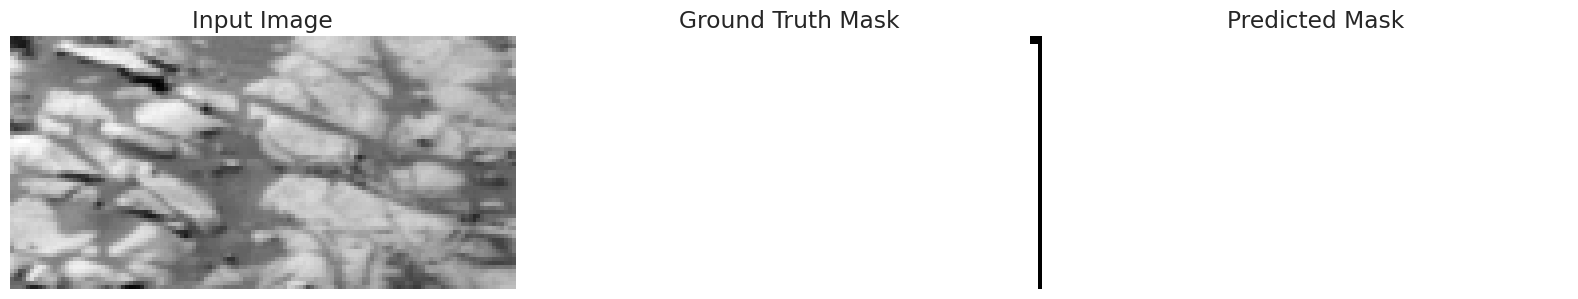

32/32 - 1s - 43ms/step - accuracy: 0.9476 - loss: 0.1299 - mean_iou: 0.8671 - val_accuracy: 0.8105 - val_loss: 0.6369 - val_mean_iou: 0.5860
Epoch 42/150
32/32 - 1s - 28ms/step - accuracy: 0.9476 - loss: 0.1323 - mean_iou: 0.8675 - val_accuracy: 0.8152 - val_loss: 0.5837 - val_mean_iou: 0.5898
Epoch 43/150
32/32 - 1s - 28ms/step - accuracy: 0.9493 - loss: 0.1254 - mean_iou: 0.8714 - val_accuracy: 0.8158 - val_loss: 0.6269 - val_mean_iou: 0.5919
Epoch 44/150
32/32 - 1s - 29ms/step - accuracy: 0.9507 - loss: 0.1223 - mean_iou: 0.8745 - val_accuracy: 0.8212 - val_loss: 0.5979 - val_mean_iou: 0.5900
Epoch 45/150
32/32 - 1s - 28ms/step - accuracy: 0.9534 - loss: 0.1143 - mean_iou: 0.8815 - val_accuracy: 0.8187 - val_loss: 0.6447 - val_mean_iou: 0.5795
Epoch 46/150
32/32 - 1s - 28ms/step - accuracy: 0.9526 - loss: 0.1163 - mean_iou: 0.8794 - val_accuracy: 0.8195 - val_loss: 0.6817 - val_mean_iou: 0.5667
Epoch 47/150
32/32 - 1s - 28ms/step - accuracy: 0.9462 - loss: 0.1328 - mean_iou: 0.8636 

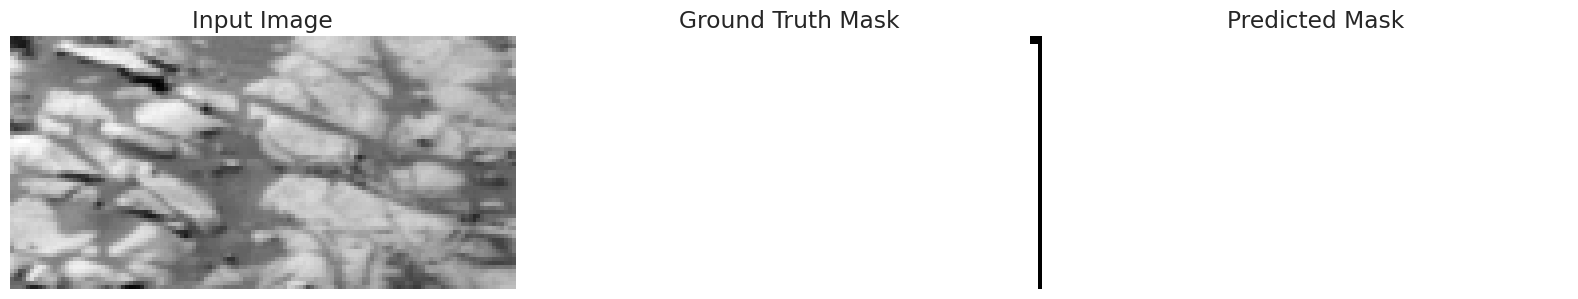

32/32 - 1s - 43ms/step - accuracy: 0.9583 - loss: 0.1036 - mean_iou: 0.8931 - val_accuracy: 0.8219 - val_loss: 0.6059 - val_mean_iou: 0.6000
Epoch 52/150
32/32 - 1s - 29ms/step - accuracy: 0.9607 - loss: 0.0967 - mean_iou: 0.8993 - val_accuracy: 0.8246 - val_loss: 0.6210 - val_mean_iou: 0.6082
Epoch 53/150
32/32 - 1s - 28ms/step - accuracy: 0.9616 - loss: 0.0938 - mean_iou: 0.9010 - val_accuracy: 0.8256 - val_loss: 0.6569 - val_mean_iou: 0.5933
Epoch 54/150
32/32 - 1s - 28ms/step - accuracy: 0.9621 - loss: 0.0921 - mean_iou: 0.9023 - val_accuracy: 0.8147 - val_loss: 0.6663 - val_mean_iou: 0.5982
Epoch 55/150
32/32 - 1s - 28ms/step - accuracy: 0.9630 - loss: 0.0903 - mean_iou: 0.9046 - val_accuracy: 0.8247 - val_loss: 0.6717 - val_mean_iou: 0.5895
Epoch 56/150
32/32 - 1s - 28ms/step - accuracy: 0.9625 - loss: 0.0908 - mean_iou: 0.9034 - val_accuracy: 0.8212 - val_loss: 0.7411 - val_mean_iou: 0.5817
Epoch 57/150
32/32 - 1s - 29ms/step - accuracy: 0.9640 - loss: 0.0872 - mean_iou: 0.9071 

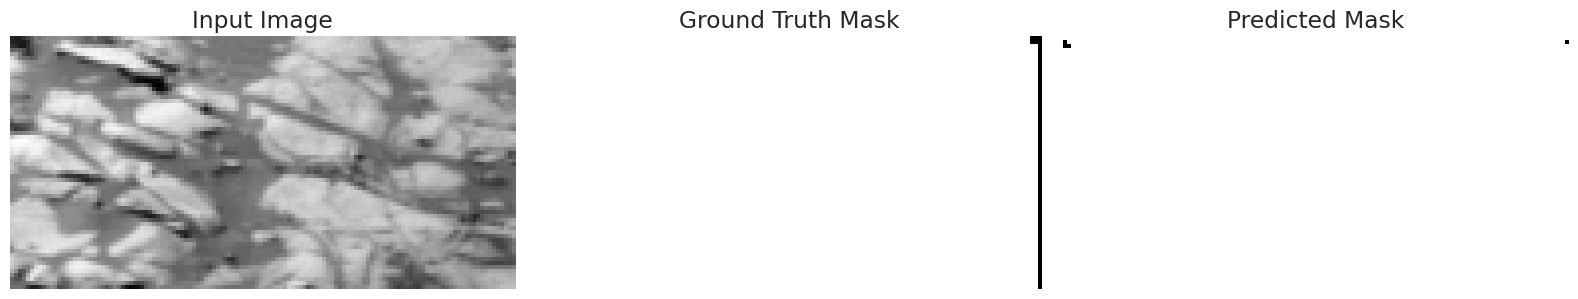

32/32 - 1s - 43ms/step - accuracy: 0.9636 - loss: 0.0894 - mean_iou: 0.9062 - val_accuracy: 0.8169 - val_loss: 0.7660 - val_mean_iou: 0.5728
Epoch 62/150
32/32 - 1s - 28ms/step - accuracy: 0.9670 - loss: 0.0806 - mean_iou: 0.9144 - val_accuracy: 0.8209 - val_loss: 0.7316 - val_mean_iou: 0.5874
Epoch 63/150
32/32 - 1s - 29ms/step - accuracy: 0.9687 - loss: 0.0757 - mean_iou: 0.9186 - val_accuracy: 0.8209 - val_loss: 0.7593 - val_mean_iou: 0.5810
Epoch 64/150
32/32 - 1s - 28ms/step - accuracy: 0.9705 - loss: 0.0713 - mean_iou: 0.9233 - val_accuracy: 0.8251 - val_loss: 0.7524 - val_mean_iou: 0.5927
Epoch 65/150
32/32 - 1s - 29ms/step - accuracy: 0.9698 - loss: 0.0731 - mean_iou: 0.9216 - val_accuracy: 0.8184 - val_loss: 0.7538 - val_mean_iou: 0.5750
Epoch 66/150
32/32 - 1s - 29ms/step - accuracy: 0.9713 - loss: 0.0691 - mean_iou: 0.9253 - val_accuracy: 0.8180 - val_loss: 0.7979 - val_mean_iou: 0.5668
Epoch 67/150
32/32 - 1s - 28ms/step - accuracy: 0.9715 - loss: 0.0685 - mean_iou: 0.9260 

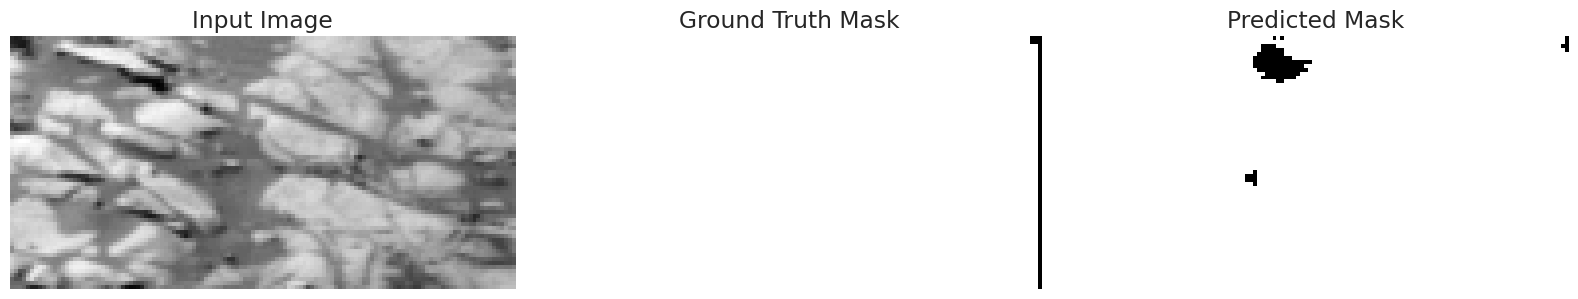

32/32 - 1s - 44ms/step - accuracy: 0.9726 - loss: 0.0659 - mean_iou: 0.9285 - val_accuracy: 0.8213 - val_loss: 0.7549 - val_mean_iou: 0.5910
Epoch 72/150
32/32 - 1s - 29ms/step - accuracy: 0.9744 - loss: 0.0614 - mean_iou: 0.9330 - val_accuracy: 0.8235 - val_loss: 0.8014 - val_mean_iou: 0.5925
Epoch 73/150
32/32 - 1s - 28ms/step - accuracy: 0.9752 - loss: 0.0600 - mean_iou: 0.9351 - val_accuracy: 0.8220 - val_loss: 0.8131 - val_mean_iou: 0.5815
Epoch 74/150
32/32 - 1s - 28ms/step - accuracy: 0.9762 - loss: 0.0567 - mean_iou: 0.9377 - val_accuracy: 0.8246 - val_loss: 0.7852 - val_mean_iou: 0.5894
Epoch 75/150
32/32 - 1s - 28ms/step - accuracy: 0.9764 - loss: 0.0568 - mean_iou: 0.9381 - val_accuracy: 0.8225 - val_loss: 0.7951 - val_mean_iou: 0.5877
Epoch 76/150
32/32 - 1s - 28ms/step - accuracy: 0.9772 - loss: 0.0550 - mean_iou: 0.9402 - val_accuracy: 0.8227 - val_loss: 0.7872 - val_mean_iou: 0.5931
Epoch 77/150
32/32 - 1s - 28ms/step - accuracy: 0.9768 - loss: 0.0567 - mean_iou: 0.9392 

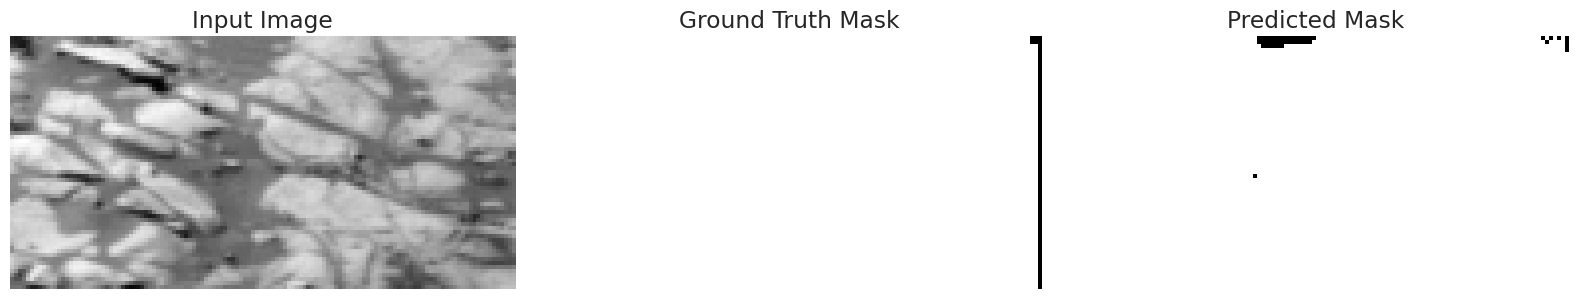

32/32 - 1s - 43ms/step - accuracy: 0.9784 - loss: 0.0521 - mean_iou: 0.9433 - val_accuracy: 0.8252 - val_loss: 0.8098 - val_mean_iou: 0.5898
Epoch 82/150
32/32 - 1s - 32ms/step - accuracy: 0.9778 - loss: 0.0537 - mean_iou: 0.9416 - val_accuracy: 0.8286 - val_loss: 0.8001 - val_mean_iou: 0.6003
Epoch 83/150
32/32 - 1s - 29ms/step - accuracy: 0.9781 - loss: 0.0530 - mean_iou: 0.9425 - val_accuracy: 0.8237 - val_loss: 0.7857 - val_mean_iou: 0.5935
Epoch 84/150
32/32 - 1s - 28ms/step - accuracy: 0.9791 - loss: 0.0504 - mean_iou: 0.9449 - val_accuracy: 0.8237 - val_loss: 0.7995 - val_mean_iou: 0.5867
Epoch 85/150
32/32 - 1s - 28ms/step - accuracy: 0.9807 - loss: 0.0466 - mean_iou: 0.9490 - val_accuracy: 0.8186 - val_loss: 0.8226 - val_mean_iou: 0.5727
Epoch 86/150
32/32 - 1s - 29ms/step - accuracy: 0.9813 - loss: 0.0450 - mean_iou: 0.9507 - val_accuracy: 0.8229 - val_loss: 0.8237 - val_mean_iou: 0.5850
Epoch 87/150
32/32 - 1s - 29ms/step - accuracy: 0.9820 - loss: 0.0432 - mean_iou: 0.9525 

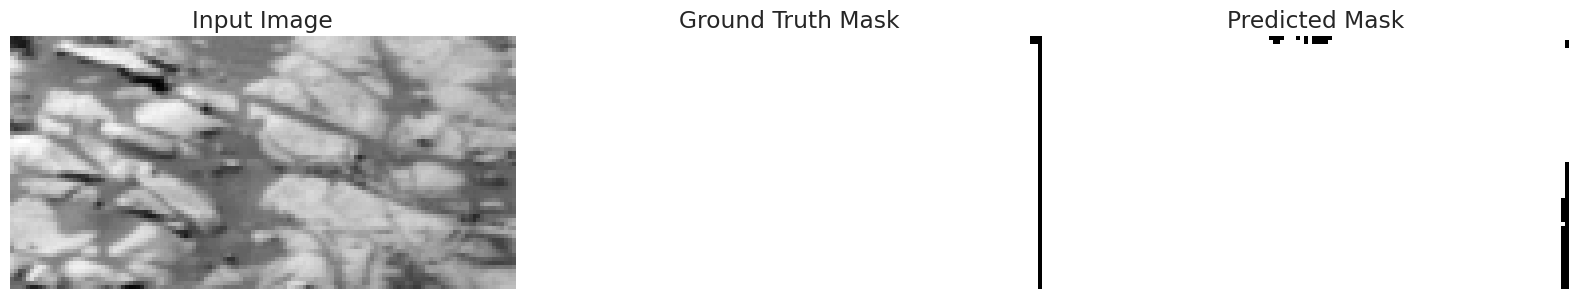

32/32 - 1s - 43ms/step - accuracy: 0.9832 - loss: 0.0407 - mean_iou: 0.9554 - val_accuracy: 0.8208 - val_loss: 0.8494 - val_mean_iou: 0.5853
Epoch 92/150
32/32 - 1s - 30ms/step - accuracy: 0.9834 - loss: 0.0402 - mean_iou: 0.9560 - val_accuracy: 0.8223 - val_loss: 0.8311 - val_mean_iou: 0.5982
Epoch 93/150
32/32 - 1s - 29ms/step - accuracy: 0.9841 - loss: 0.0382 - mean_iou: 0.9578 - val_accuracy: 0.8212 - val_loss: 0.8353 - val_mean_iou: 0.6007
Epoch 94/150
32/32 - 1s - 29ms/step - accuracy: 0.9845 - loss: 0.0372 - mean_iou: 0.9589 - val_accuracy: 0.8203 - val_loss: 0.8724 - val_mean_iou: 0.5917
Epoch 95/150
32/32 - 1s - 29ms/step - accuracy: 0.9832 - loss: 0.0402 - mean_iou: 0.9555 - val_accuracy: 0.8171 - val_loss: 0.9043 - val_mean_iou: 0.5765
Epoch 96/150
32/32 - 1s - 29ms/step - accuracy: 0.9830 - loss: 0.0402 - mean_iou: 0.9551 - val_accuracy: 0.8167 - val_loss: 0.8927 - val_mean_iou: 0.5865
Epoch 97/150
32/32 - 1s - 29ms/step - accuracy: 0.9832 - loss: 0.0398 - mean_iou: 0.9556 

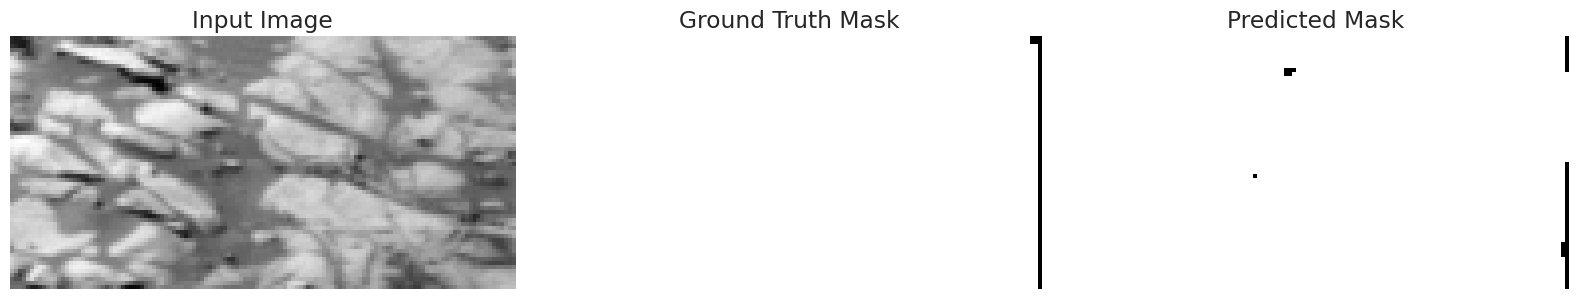

32/32 - 1s - 44ms/step - accuracy: 0.9860 - loss: 0.0335 - mean_iou: 0.9629 - val_accuracy: 0.8231 - val_loss: 0.8510 - val_mean_iou: 0.5950
Epoch 102/150
32/32 - 1s - 29ms/step - accuracy: 0.9860 - loss: 0.0340 - mean_iou: 0.9627 - val_accuracy: 0.8226 - val_loss: 0.8973 - val_mean_iou: 0.5849
Epoch 103/150
32/32 - 1s - 29ms/step - accuracy: 0.9854 - loss: 0.0350 - mean_iou: 0.9611 - val_accuracy: 0.8200 - val_loss: 0.9054 - val_mean_iou: 0.5794
Epoch 104/150
32/32 - 1s - 30ms/step - accuracy: 0.9857 - loss: 0.0344 - mean_iou: 0.9619 - val_accuracy: 0.8170 - val_loss: 0.9134 - val_mean_iou: 0.5781
Epoch 105/150
32/32 - 1s - 28ms/step - accuracy: 0.9853 - loss: 0.0350 - mean_iou: 0.9609 - val_accuracy: 0.8180 - val_loss: 0.9292 - val_mean_iou: 0.5778
Epoch 106/150
32/32 - 1s - 29ms/step - accuracy: 0.9847 - loss: 0.0363 - mean_iou: 0.9595 - val_accuracy: 0.8200 - val_loss: 0.9072 - val_mean_iou: 0.5848
Epoch 107/150
32/32 - 1s - 29ms/step - accuracy: 0.9852 - loss: 0.0353 - mean_iou: 0

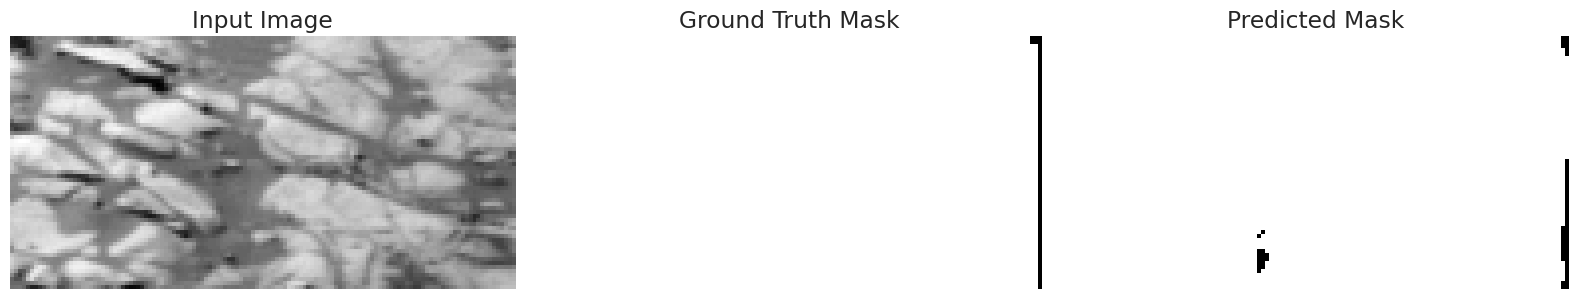

32/32 - 1s - 42ms/step - accuracy: 0.9875 - loss: 0.0301 - mean_iou: 0.9666 - val_accuracy: 0.8222 - val_loss: 0.8722 - val_mean_iou: 0.5919
Epoch 112/150
32/32 - 1s - 28ms/step - accuracy: 0.9878 - loss: 0.0293 - mean_iou: 0.9676 - val_accuracy: 0.8219 - val_loss: 0.8941 - val_mean_iou: 0.5892
Epoch 113/150
32/32 - 1s - 28ms/step - accuracy: 0.9887 - loss: 0.0275 - mean_iou: 0.9697 - val_accuracy: 0.8219 - val_loss: 0.8997 - val_mean_iou: 0.5911
Epoch 114/150
32/32 - 1s - 28ms/step - accuracy: 0.9888 - loss: 0.0273 - mean_iou: 0.9700 - val_accuracy: 0.8223 - val_loss: 0.9043 - val_mean_iou: 0.5919
Epoch 115/150
32/32 - 1s - 29ms/step - accuracy: 0.9888 - loss: 0.0273 - mean_iou: 0.9701 - val_accuracy: 0.8216 - val_loss: 0.9120 - val_mean_iou: 0.5887
Epoch 116/150
32/32 - 1s - 29ms/step - accuracy: 0.9893 - loss: 0.0262 - mean_iou: 0.9713 - val_accuracy: 0.8214 - val_loss: 0.9246 - val_mean_iou: 0.5866
Epoch 117/150
32/32 - 1s - 29ms/step - accuracy: 0.9892 - loss: 0.0264 - mean_iou: 0

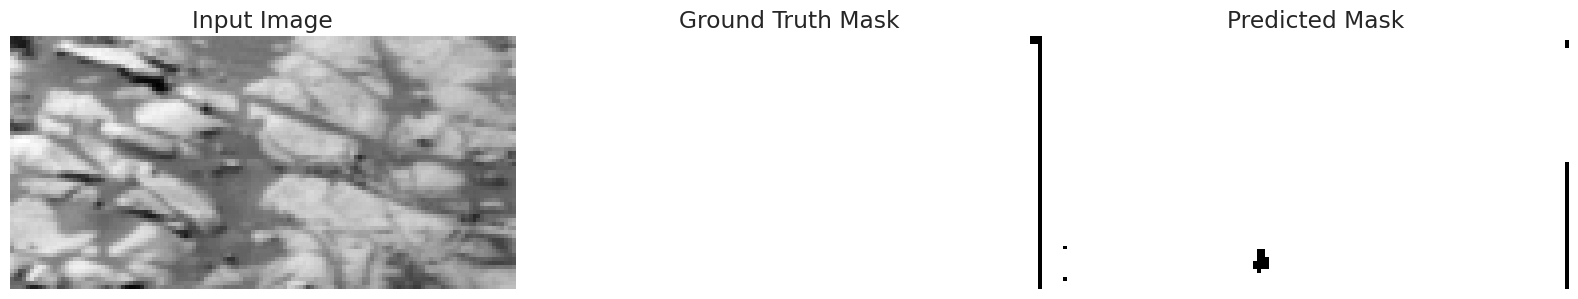

32/32 - 1s - 42ms/step - accuracy: 0.9898 - loss: 0.0248 - mean_iou: 0.9729 - val_accuracy: 0.8222 - val_loss: 0.9458 - val_mean_iou: 0.5879
Epoch 122/150
32/32 - 1s - 28ms/step - accuracy: 0.9902 - loss: 0.0241 - mean_iou: 0.9738 - val_accuracy: 0.8218 - val_loss: 0.9535 - val_mean_iou: 0.5871
Epoch 123/150
32/32 - 1s - 28ms/step - accuracy: 0.9900 - loss: 0.0243 - mean_iou: 0.9734 - val_accuracy: 0.8228 - val_loss: 0.9518 - val_mean_iou: 0.5884
Epoch 124/150
32/32 - 1s - 28ms/step - accuracy: 0.9905 - loss: 0.0234 - mean_iou: 0.9746 - val_accuracy: 0.8224 - val_loss: 0.9445 - val_mean_iou: 0.5895
Epoch 125/150
32/32 - 1s - 29ms/step - accuracy: 0.9904 - loss: 0.0235 - mean_iou: 0.9743 - val_accuracy: 0.8226 - val_loss: 0.9568 - val_mean_iou: 0.5881
Epoch 126/150
32/32 - 1s - 28ms/step - accuracy: 0.9905 - loss: 0.0235 - mean_iou: 0.9746 - val_accuracy: 0.8220 - val_loss: 0.9531 - val_mean_iou: 0.5885
Epoch 127/150
32/32 - 1s - 29ms/step - accuracy: 0.9905 - loss: 0.0232 - mean_iou: 0

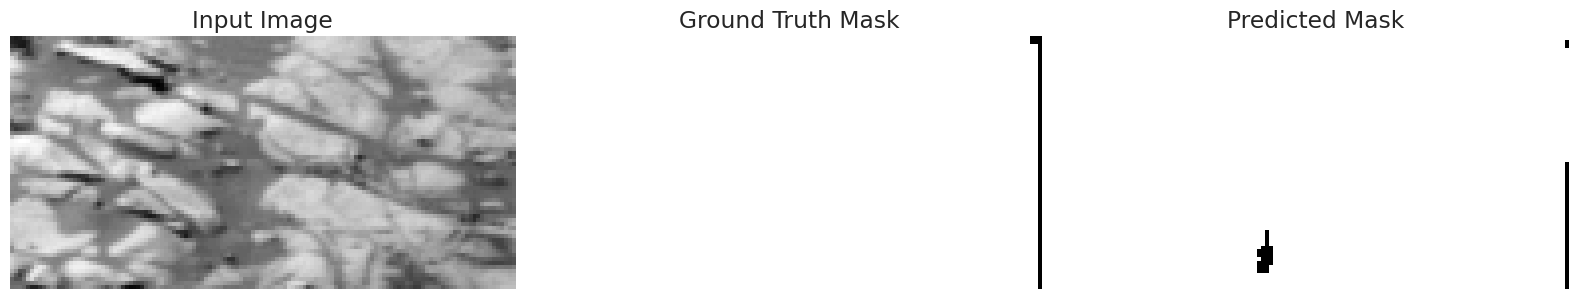

32/32 - 1s - 42ms/step - accuracy: 0.9907 - loss: 0.0230 - mean_iou: 0.9751 - val_accuracy: 0.8214 - val_loss: 0.9599 - val_mean_iou: 0.5868
Epoch 132/150
32/32 - 1s - 28ms/step - accuracy: 0.9910 - loss: 0.0222 - mean_iou: 0.9759 - val_accuracy: 0.8217 - val_loss: 0.9571 - val_mean_iou: 0.5884
Best epoch:     52
Final val loss:    0.621
Final accuracy:    82.46%
Final meanIoU:     60.82%
Plotting 2 validation images...


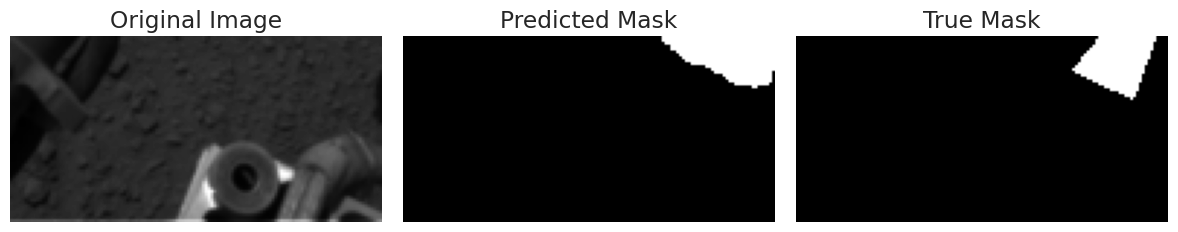

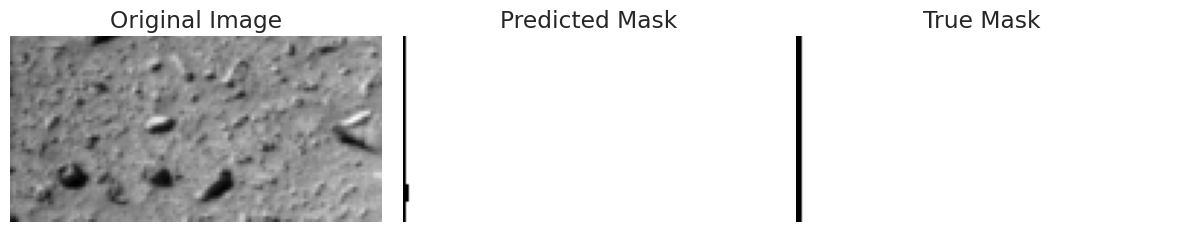

Plotting 1 test images...


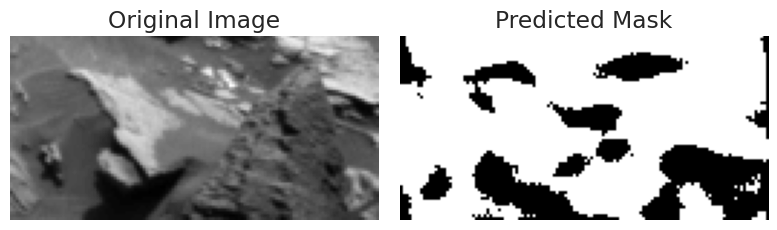

In [ ]:
class_dict = {
  0: 'Background',
  1: 'Foreground'
}

NUM_CLASSES = len(class_dict)

binarycolormap = plt.cm.gray(np.linspace(0, 1, NUM_CLASSES))

BATCH_SIZE = 64
PATIENCE = 50
EPOCHS = 150
MODEL = "residual_unet"
NUM_LEVELS = 5
LOSS = "cce"
LOSS_WEIGHTS = [1]
CLASS_WEIGHTS = [[1,1]]
MODEL_VERBOSE = 2
FULL_VERBOSE = 1
PLOT_VAL = 2
PLOT_TEST = 1

SAVE_MODEL = config["SAVE_MODEL"]
SUBMISSION = config["SUBMISSION"]

# Load the training data
data = np.load("./mars_cleaned.npz")
training_set = data["training_set"]
X_train_val = training_set[:, 0]
y_train_val = training_set[:, 1]
y_train_val = np.array([create_binary_background_mask(mask) for mask in y_train_val])

# Reshape the data
X_train_val = X_train_val[..., np.newaxis] / 255.0

# Split the data into training, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=seed
)

input_shape = X_train.shape[1:]

######################### ONEHOT ENCODING ##################################
y_train = tf.one_hot(tf.cast(y_train, tf.int32), depth=NUM_CLASSES)
y_val = tf.one_hot(tf.cast(y_val, tf.int32), depth=NUM_CLASSES)

########################### BUILD DATASET ##################################
train_dataset = make_dataset(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True, augment=True, augmentation=None, seed=seed)
val_dataset = make_dataset(X_val, y_val, batch_size=BATCH_SIZE, shuffle=False)

########################### LOSSES #########################################
loss_fns = get_loss_function(LOSS, weights=LOSS_WEIGHTS, class_weights=CLASS_WEIGHTS)

########################### CALLBACKS ######################################
callbacks = []
callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=PATIENCE, restore_best_weights=True))
callbacks.append(VizCallback(X_val[0], y_val[0], binarycolormap,frequency=10))
########################## SET LEARNING RATE ###############################
steps_per_epoch = (len(X_train) // BATCH_SIZE )
learning_rate = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=LEARNING_RATE,decay_steps=EPOCHS*steps_per_epoch,alpha=1e-2)

########################## SET MODEL #######################################
model = get_model(MODEL, input_shape=input_shape, num_classes=NUM_CLASSES, seed=seed, num_levels=NUM_LEVELS)

########################### COMPILE MODEL ##################################
# Compile Model
model.compile(
    loss=loss_fns,
    optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[])]
)

history = model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, callbacks=callbacks, verbose=MODEL_VERBOSE).history

########################### EVALUATE #######################################
y_true = np.array(np.argmax(y_val.numpy(), axis=-1).flatten())
y_pred = np.array(np.argmax(model.predict(X_val, verbose=0), axis=-1).flatten())

######################### OVERALL PERFORMANCE ##############################
best_epoch = history['val_mean_iou'].index(max(history['val_mean_iou'])) + 1
final_val_meanIoU = round(history['val_mean_iou'][best_epoch - 1] * 100, 2)
final_val_accuracy = round(history['val_accuracy'][best_epoch - 1] * 100, 2)
final_val_loss = round(history['val_loss'][best_epoch - 1], 4)

print(f'Best epoch:     {best_epoch}')
print(f'Final val loss:   {final_val_loss:6.3f}')
print(f'Final accuracy:   {final_val_accuracy:6.2f}%')
print(f'Final meanIoU:    {final_val_meanIoU:6.2f}%')

if PLOT_VAL is not None:
    print("Plotting " + str(PLOT_VAL) + " validation images...")
    plot_triptychs(X_val, y_val, model, num_samples=PLOT_VAL, colormap=binarycolormap)

########################### SAVE MODEL #####################################
if SAVE_MODEL == True:
    # Save the trained model to a file with the accuracy included in the filename
    model_filename = model_name + "_" + version + "_"+str(final_val_meanIoU)+'.keras'
    model.save(model_filename)
    config["model_filename"] = model_filename
    print(f"Model saved as {model_filename}")

########################### INFERENCE ######################################
preds = model.predict(test_dataset, verbose=0)
preds = np.argmax(preds, axis=-1)
# print(f"Predictions shape: {preds.shape}")

########################### PLOT TEST #######################################
if PLOT_TEST is not None:
    print("Plotting " + str(PLOT_TEST) + " test images...")
    plot_triptychs(X_test, None, model, num_samples=PLOT_TEST, colormap=binarycolormap)

del model


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step


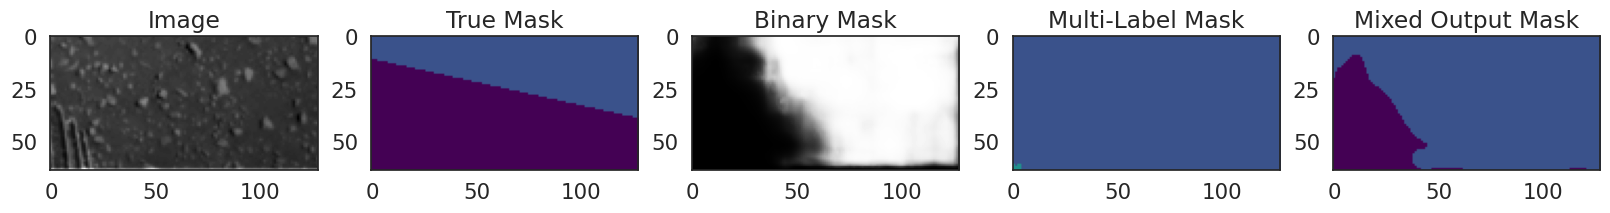

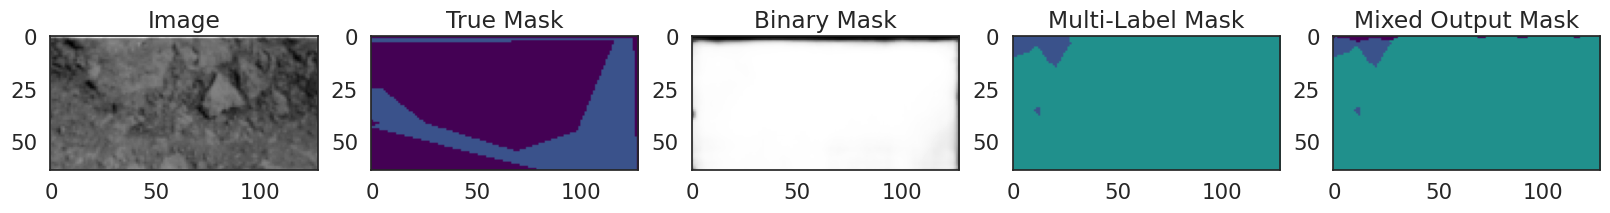

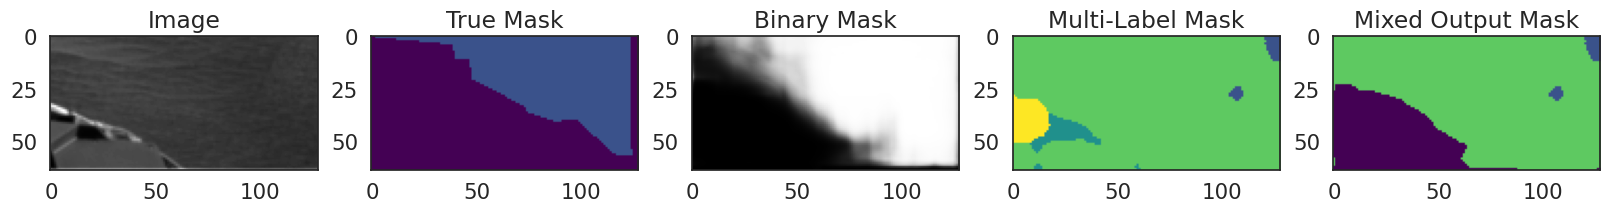

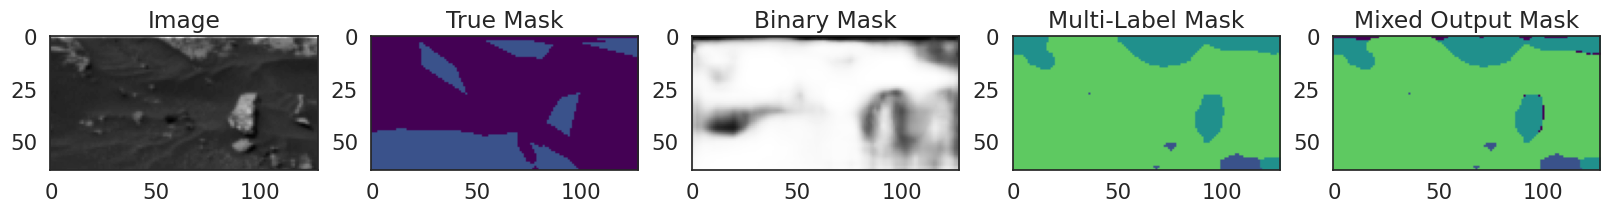

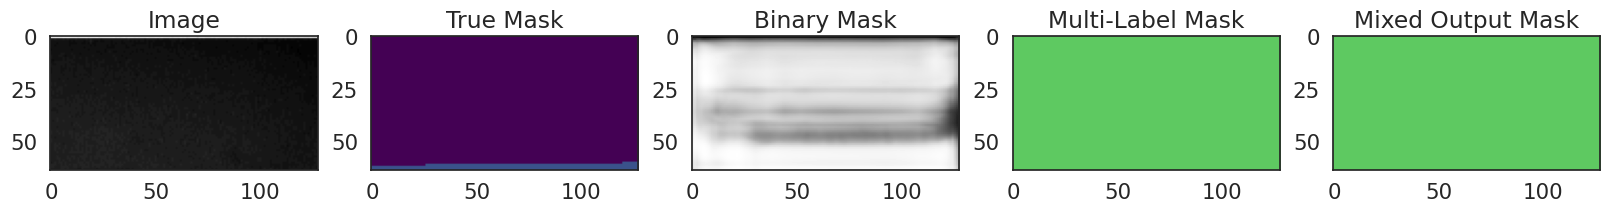

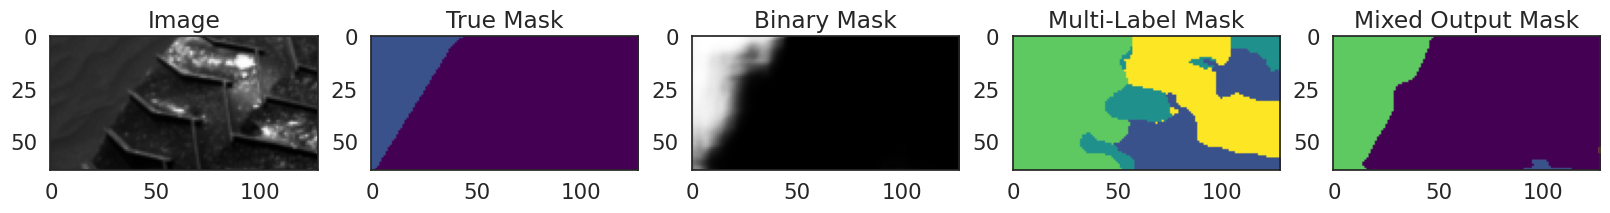

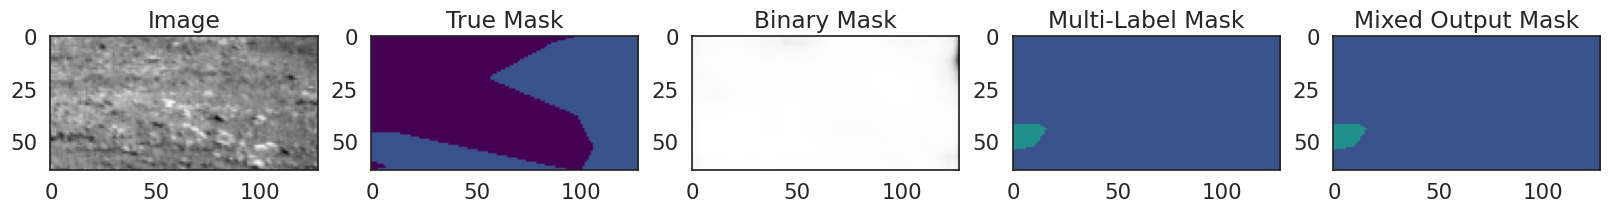

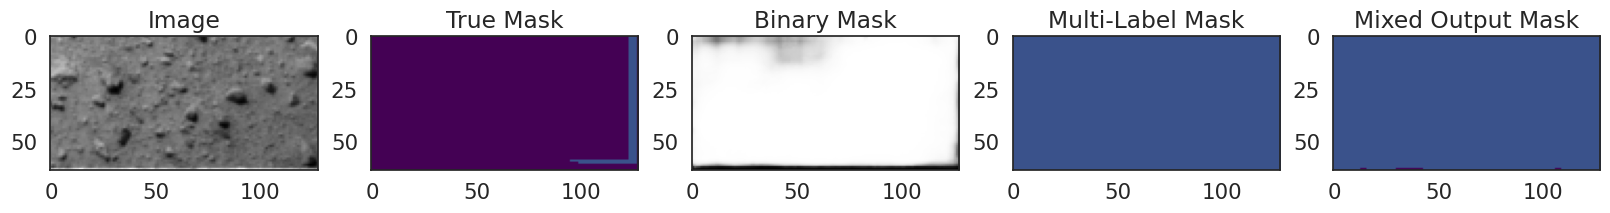

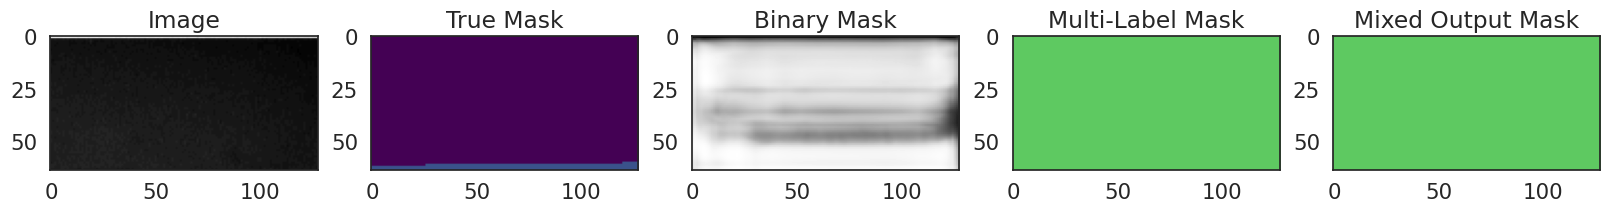

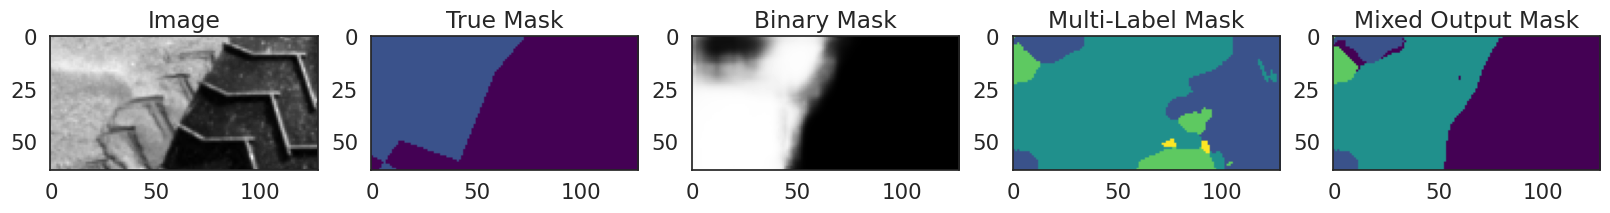

In [ ]:
binary_model_name = "M_Background_1.10_62.33.keras"
multi_model_name = "M_UNet3p_2.4_65.91.keras"

binary_output, multiclass_output, mixed_output = make_mixed_predictions(X_val, binary_model_name, multi_model_name)

compare_mixed_outputs(X_val, y_val, binary_output, multiclass_output, mixed_output, 10, colormap)